In [1]:
# import stuff
import os.path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn
from motornet.plants.muscles import RigidTendonHillMuscleThelen

2023-05-16 09:50:50.629528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 09:50:51.817146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /srv/software/itksnap/itksnap-3.8.2-alpha-20200410-Linux-gcc64-qt4/lib/snap-3.8.2-alpha:/srv/software/freesurfer/6.0.0/lib
2023-05-16 09:50:51.817177: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 09:51:00.079899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64

In [2]:
# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

2023-05-16 09:51:16.206622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-16 09:51:16.206666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AFI-CBS-B1): /proc/driver/nvidia/version does not exist


# Define a centre-out reaching task with NF/FF

In [3]:
# define a Centre-out FF reaching task

import copy
import numpy as np
import tensorflow as tf
from motornet.nets.losses import PositionLoss, L2xDxActivationLoss, L2xDxRegularizer, CompoundedLoss
from motornet.tasks import Task
from typing import Union

class CentreOutFF(Task):
    def __init__(
            self,
            network,
            name: str = 'CentreOutReach',
            angular_step: float = 15,
            catch_trial_perc: float = 50,
            reaching_distance: float = 0.1,
            start_position: Union[list, tuple, np.ndarray] = None,
            deriv_weight: float = 0.,
            go_cue_range: Union[list, tuple, np.ndarray] = (0.10, 0.30),
            **kwargs
    ):

        super().__init__(network, name=name, **kwargs)

        self.angular_step = angular_step
        self.catch_trial_perc = catch_trial_perc
        self.reaching_distance = reaching_distance
        self.start_position = start_position
        if not self.start_position:
            # start at the center of the workspace
            lb = np.array(self.network.plant.pos_lower_bound)
            ub = np.array(self.network.plant.pos_upper_bound)
            self.start_position = lb + (ub - lb) / 2
        self.start_position = np.array(self.start_position).reshape(1, -1).tolist()

        muscle_loss = L2xDxActivationLoss(
            max_iso_force=self.network.plant.muscle.max_iso_force,
            dt=self.network.plant.dt,
            deriv_weight=deriv_weight
        )
        self.add_loss('muscle state',       loss_weight=5.0, loss=muscle_loss)          # 5.0

        gru_loss = L2xDxRegularizer(       deriv_weight=0.05, dt=self.network.plant.dt) # 0.05
        self.add_loss('gru_hidden_0',       loss_weight=0.1, loss=gru_loss)             # 0.1

        self.add_loss('cartesian position', loss_weight=2.0, loss=PositionLoss())       # 2.0

        go_cue_range = np.array(go_cue_range) / self.network.plant.dt
        self.go_cue_range = [int(go_cue_range[0]), int(go_cue_range[1])]
        self.delay_range = self.go_cue_range

        # CW by default
        self.FF_matvel = tf.convert_to_tensor(kwargs.get('FF_matvel', np.array([[0,1],[-1,0]])), dtype=tf.float32)
        self.FF_matvel_x = tf.slice(self.FF_matvel, [0, 0], [1, -1])
        self.FF_matvel_y = tf.slice(self.FF_matvel, [1, 0], [1, -1])

        self.apply_ff = tf.keras.layers.Lambda(
            lambda x: x[0] * tf.concat(
                [
                    tf.reduce_sum(self.FF_matvel_x * x[1], axis=1, keepdims=True),
                    tf.reduce_sum(self.FF_matvel_y * x[1], axis=1, keepdims=True),
                ], axis=1),
            name="apply_force_field"
        )

    def generate(self, batch_size, n_timesteps, condition="test", ff_coefficient: float = 0.):
        """
        condition = "train": learn to reach to random targets in workspace in a NF
                    "test" : centre-out reaches to each target in a given FF/NF
                    "adapt": re-learn centre-out reaches in a given FF/NF
        """
        catch_trial = np.zeros(batch_size, dtype='float32')
        if (condition=="train"): # train net to reach to random targets in workspace in a NF
            init_states   = self.get_initial_state(batch_size=batch_size)
            goal_states_j = self.network.plant.draw_random_uniform_states(batch_size=batch_size)
            goal_states   = self.network.plant.joint2cartesian(goal_states_j)
            p             = int(np.floor(batch_size * self.catch_trial_perc / 100))
            catch_trial[np.random.permutation(catch_trial.size)[:p]] = 1.
            
        elif (condition=="test"): # centre-out reaches to each target in a given FF/NF
            angle_set   = np.deg2rad(np.arange(0, 360, self.angular_step))
            reps        = int(np.ceil(batch_size / len(angle_set)))
            angle       = np.tile(angle_set, reps=reps)
            batch_size  = reps * len(angle_set)
            start_jpv   = np.concatenate([self.start_position, np.zeros_like(self.start_position)], axis=1)
            start_cpv   = self.network.plant.joint2cartesian(start_jpv)
            end_cp      = self.reaching_distance * np.stack([np.cos(angle), np.sin(angle)], axis=-1)
            init_states = self.network.get_initial_state(batch_size=batch_size, inputs=start_jpv)
            goal_states = start_cpv + np.concatenate([end_cp, np.zeros_like(end_cp)], axis=-1)
            catch_trial = np.zeros(batch_size, dtype='float32')

        elif (condition=="adapt"): # re-learn centre-out reaches in a given FF/NF
            angle_set   = np.deg2rad(np.arange(0, 360, self.angular_step))
            reps        = int(np.ceil(batch_size / len(angle_set)))
            angle       = np.tile(angle_set, reps=reps)
            batch_size  = reps * len(angle_set)
            start_jpv   = np.concatenate([self.start_position, np.zeros_like(self.start_position)], axis=1)
            start_cpv   = self.network.plant.joint2cartesian(start_jpv)
            end_cp      = self.reaching_distance * np.stack([np.cos(angle), np.sin(angle)], axis=-1)
            init_states = self.network.get_initial_state(batch_size=batch_size, inputs=start_jpv)
            goal_states = start_cpv + np.concatenate([end_cp, np.zeros_like(end_cp)], axis=-1)
            p             = int(np.floor(batch_size * self.catch_trial_perc / 100))
            catch_trial[np.random.permutation(catch_trial.size)[:p]] = 1.

        startpos     = self.network.plant.joint2cartesian(init_states[0][:, :])
        go_cue       = np.ones([batch_size, n_timesteps, 1])
        targets      = self.network.plant.state2target(state=goal_states, n_timesteps=n_timesteps).numpy()
        inputs_targ  = copy.deepcopy(targets[:, :, :self.network.plant.space_dim])
        tmp          = np.repeat(startpos[:, np.newaxis, :self.network.plant.space_dim], n_timesteps, axis=1)
        inputs_start = copy.deepcopy(tmp)
        for i in range(batch_size):
            if ((condition=="train") or (condition=="adapt")):
                go_cue_time = int(np.random.uniform(self.go_cue_range[0], self.go_cue_range[1]))
            elif (condition=="test"):
                go_cue_time = int((self.go_cue_range[0]+self.go_cue_range[1])/2)
            if catch_trial[i] > 0.:
                targets[i, :, :] = startpos[i, np.newaxis, :]
            else:
                targets[i, :go_cue_time, :] = startpos[i, np.newaxis, :]
                inputs_start[i, go_cue_time + self.network.visual_delay:, :] = 0.
                go_cue[i, go_cue_time + self.network.visual_delay:, 0] = 0.

        inputs = {
            "inputs": np.concatenate([inputs_start, inputs_targ, go_cue], axis=-1),
            "ff_coefficient": ff_coefficient * np.ones((batch_size, n_timesteps, 1)),
        }
        return [inputs, self.convert_to_tensor(targets), init_states]

    def recompute_inputs(self, inputs, states):
        b = inputs['ff_coefficient']

        _, cstate, _, _ = self.network.unpack_plant_states(states)
        vel = cstate[:, 2:]

        inputs['endpoint_load'] = self.apply_ff((b, vel))  # [2x2] x [2xbatch] = [2xbatch]
        return inputs

# Define some utility functions

In [4]:
# some utility functions

# plot hand paths
def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]
  f,ax = plt.subplots()
  nmov,ntime,_ = np.shape(xy)
  for i in range(nmov):
        ax.plot(xy[i,:,0],xy[i,:,1],color="b",linewidth=1.0)
  ax.scatter(target_x, target_y)
  ax.axis("equal")
  ax.set_xlabel("X (m)")
  ax.set_ylabel("Y (m)")
  return ax

# convert cartesian hand position to joint angles
def hand_to_joints(xy, L1, L2):
      j = np.zeros(np.shape(xy))
      j[:,:,1] = np.arccos((xy[:,:,0]**2 + xy[:,:,1]**2 - L1**2 - L2**2) / (2*L1*L2))
      j[:,:,0] = np.arctan2(xy[:,:,1],xy[:,:,0]) - np.arctan2(L2*np.sin(j[:,:,1]),L1+(L2*np.cos(j[:,:,1])))
      return j

# plot timeseries joint angles, velocities, muscle activations, and muscle forces
def plot1trial(nn, inputs, results, targets_j, trial=0):
    j_results = results['joint position']
    m_results = results['muscle state']

    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0]*180/np.pi, label='sho')
    plt.plot(j_results[trial, :, 1]*180/np.pi, label='elb')
    plt.plot(targets_j[trial, :, 0]*180/np.pi, '--')
    plt.plot(targets_j[trial, :, 1]*180/np.pi, '--')
    plt.axvline(np.where(inputs["inputs"][trial, :, -1] != 1)[0][0] - nn.task.network.visual_delay, c='grey')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (deg)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2], label='sho')
    plt.plot(j_results[trial, :, 3], label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :])
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.subplot(144)
    plt.plot(m_results[trial, :, -1, :])
    plt.xlabel('time (ms)')
    plt.ylabel('force (N)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.show()

# from Jon: If you have access only to a running average of values (M), you can calculate the value (x) added in the current iteration (n) with:
#           x(n) = nM(n) - (n-1)M(n-1)
def unwrap_loss(M):
    n = np.size(M)
    x = np.zeros(n)
    x[0] = M[0]
    for i in range(1,n):
        x[i] = (i+1)*M[i] - (i+1-1)*M[i-1]        
    return x

# average over non-overlapping windows size w;
# throws away tail of x that doesn't divide evenly into w
def window_average(x, w=10):
    rows = int(np.size(x)/w) # round to (floor) int
    cols = w
    return x[0:w*rows].reshape((rows,cols)).mean(axis=1)


# Network Training Function

In [5]:
def train_net(nn, ff_coef=0, n_epochs=100, batch_size=1024, n_batches=30):
    [inputs, targets, init_states] = nn.task.generate(
        n_timesteps    = n_t, 
        batch_size     = batch_size*n_batches, 
        condition      = "train", 
        ff_coefficient = ff_coef
        )
    callbacks = [mn.nets.callbacks.BatchLogger()]
    _ = nn.fit(x       = [inputs, init_states], 
            y          = targets, 
            verbose    = 1, 
            epochs     = n_epochs, 
            batch_size = batch_size, 
            shuffle    = True, 
            callbacks  = callbacks
            )
    position_loss_NF1 = np.zeros(0)
    for i in range(n_epochs):
        i1,i2 = i*n_batches, (i+1)*n_batches
        position_loss_NF1 = np.concatenate((position_loss_NF1,
                                            unwrap_loss(callbacks[0].history['position_loss'][i1:i2])))
    return position_loss_NF1

# Network Testing Function

In [6]:
def test_net(nn, ff_coef=0, n_mov_circle=8, plot_hand=True, plot_timeseries=True):
    # generate task
    nn.task.angular_step = 360 / n_mov_circle
    [inputs, targets, init_states] = nn.task.generate(
        n_timesteps     = n_t, 
        batch_size     = n_mov_circle, 
        condition      = "test", 
        ff_coefficient = ff_coef)

    # run network
    results = nn([inputs, init_states], training=False)

    if (plot_hand):
        # plot hand paths
        f = plot_simulations(xy=results["cartesian position"], target_xy=targets)

    if (plot_timeseries):
        # plot joint- and muscle-based time series
        L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
        targets_j = hand_to_joints(targets, L1, L2)
        n_mov = np.shape(results["joint position"])[0]
        for i in range(n_mov_circle):
            plot1trial(nn, inputs, results, targets_j, i)

# Set up a fresh network

In [7]:
# set up a fresh network

n_units = 49   # hidden units of RNN

# SET UP PLANT
plant = mn.plants.RigidTendonArm26(
    muscle_type          = RigidTendonHillMuscleThelen(),
    visual_delay         = 0.05,
    proprioceptive_delay = 0.02,
    excitation_noise_sd  = 1e-4,
    pos_lower_bound      = (np.deg2rad( 23), np.deg2rad( 26)), # keep to centre-ish of workspace
    pos_upper_bound      = (np.deg2rad(113), np.deg2rad(130))
    )

# SET UP NETWORK
network = mn.nets.layers.GRUNetwork(
    name                    = 'network',
    plant                   = plant,
    n_units                 = n_units,
    kernel_regularizer      = 1e-6,
    recurrent_regularizer   = 1e-5,
    proprioceptive_noise_sd = 1e-3,
    visual_noise_sd         = 1e-4,
    hidden_noise_sd         = 1e-3
    )

# SET UP TASK
catch_trial_perc = 50
start_position = [1.047, 1.570] # [60,90] deg
go_cue_range   = (.100, .300)
task = CentreOutFF(
    network          = network,
    start_position   = start_position,
    go_cue_range     = go_cue_range,
    catch_trial_perc = catch_trial_perc
    )
task.network.do_recompute_inputs = True
task.network.recompute_inputs = task.recompute_inputs

# SET UP RNN
rnn = tf.keras.layers.RNN(
    cell             = network,
    return_sequences = True,
    name             = 'RNN')
input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, initial_state=state0)

# SET UP MAIN NETWORK OBJECT
nn = mn.nets.MotorNetModel(
    inputs  = [input_dict, state0],
    outputs = states_out,
    name    = 'model',
    task    = task)
nn.compile(
    optimizer    = tf.optimizers.legacy.Adam(clipnorm=1.),
    loss         = task.losses,
    loss_weights = task.loss_weights)

2023-05-16 09:51:16.561101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train network to reach in a NF to random targets
## using Adam optimizer

In [8]:
# train network to reach in a NF to random targets

batch_size = 128
n_batches  = 1000
n_epochs   = 10

ff_coef = 0 # NF
n_t     = 100

callbacks = [mn.nets.callbacks.BatchLogger()]

[inputs, targets, init_states] = nn.task.generate(
    n_timesteps    = n_t, 
    batch_size     = batch_size*n_batches, 
    condition      = "train", 
    ff_coefficient = ff_coef
    )

_ = nn.fit(x          = [inputs, init_states], 
            y          = targets, 
            verbose    = 1, 
            epochs     = n_epochs, 
            batch_size = batch_size, 
            shuffle    = True, 
            callbacks  = callbacks
            )

Epoch 1/10
1000/1000 [==============================] - 206s 199ms/step - loss: 0.1302 - position_loss: 0.0596 - gru_regularizer_loss: 0.0774 - l2_xdx_activation_loss: 5.1217e-04
Epoch 2/10
1000/1000 [==============================] - 200s 199ms/step - loss: 0.0786 - position_loss: 0.0311 - gru_regularizer_loss: 0.0751 - l2_xdx_activation_loss: 0.0015
Epoch 3/10
1000/1000 [==============================] - 200s 200ms/step - loss: 0.0705 - position_loss: 0.0274 - gru_regularizer_loss: 0.0602 - l2_xdx_activation_loss: 0.0017
Epoch 4/10
1000/1000 [==============================] - 204s 204ms/step - loss: 0.0671 - position_loss: 0.0259 - gru_regularizer_loss: 0.0519 - l2_xdx_activation_loss: 0.0017
Epoch 5/10
1000/1000 [==============================] - 206s 206ms/step - loss: 0.0649 - position_loss: 0.0251 - gru_regularizer_loss: 0.0462 - l2_xdx_activation_loss: 0.0018
Epoch 6/10
1000/1000 [==============================] - 204s 204ms/step - loss: 0.0634 - position_loss: 0.0245 - gru_regu

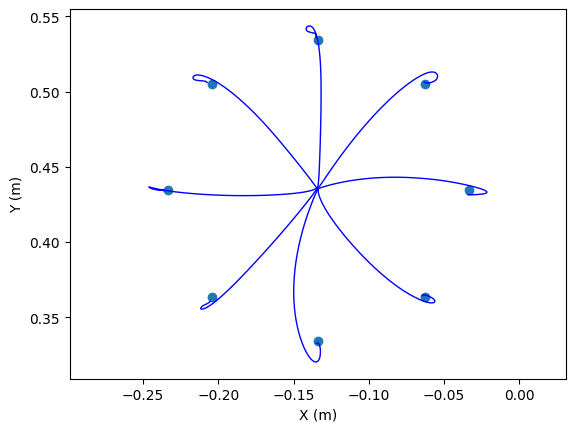

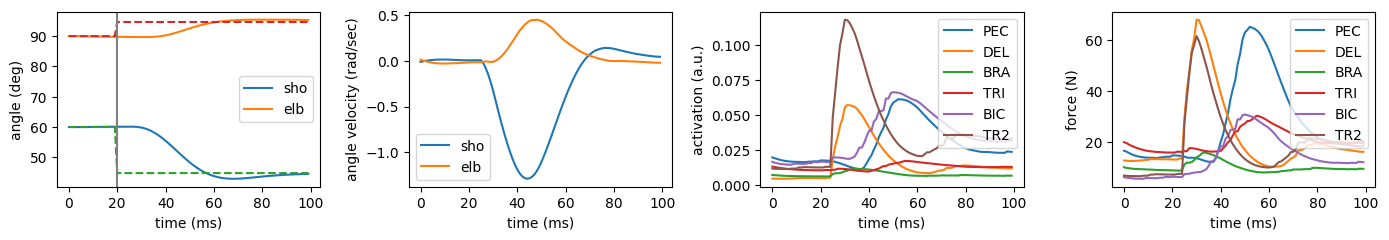

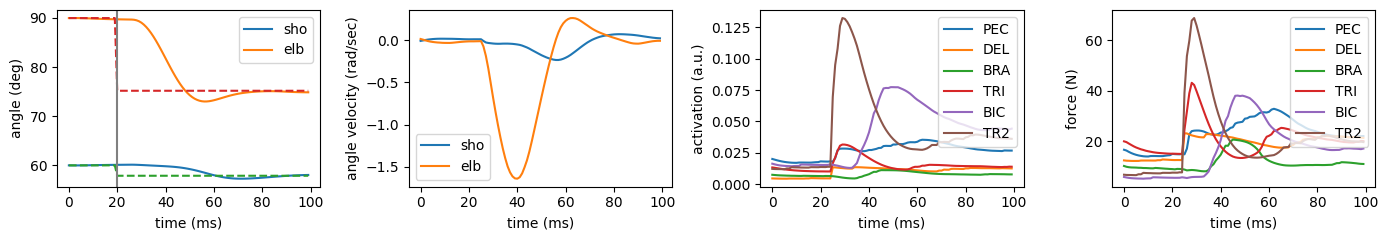

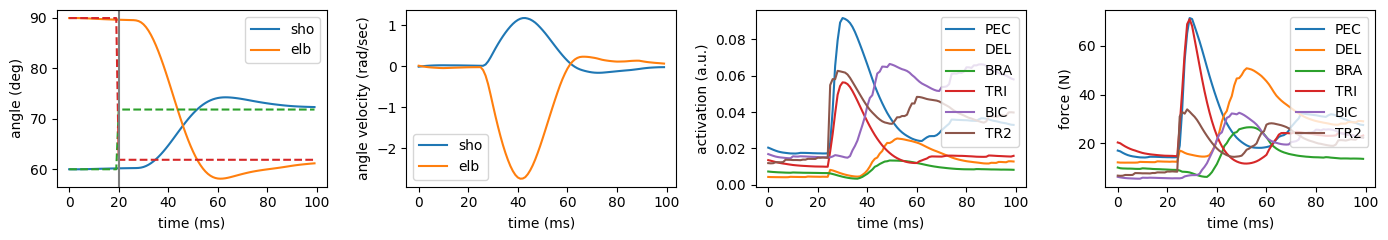

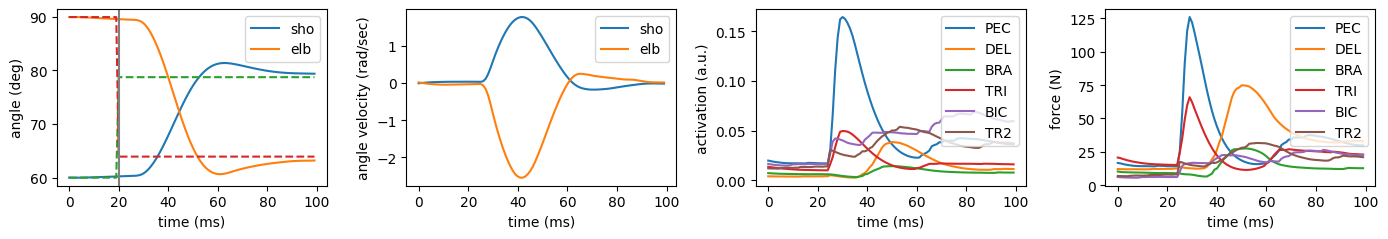

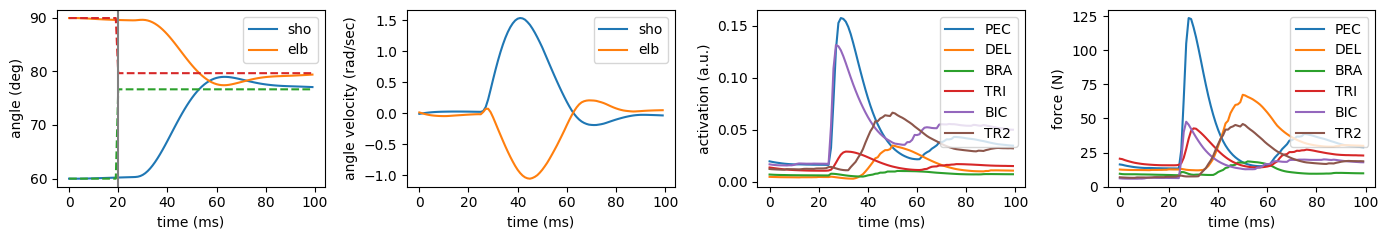

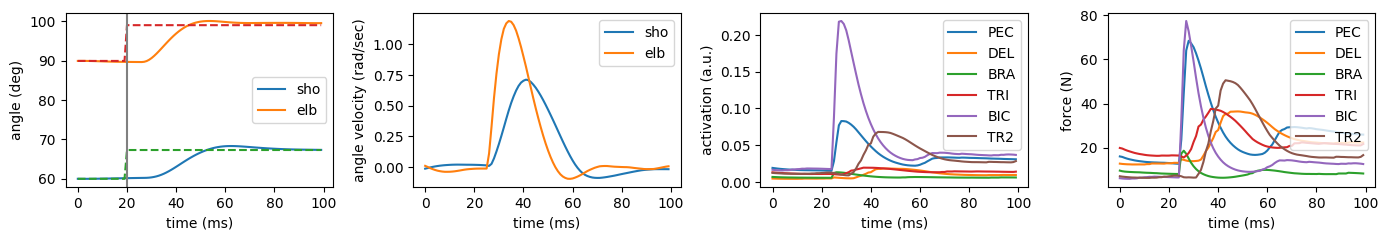

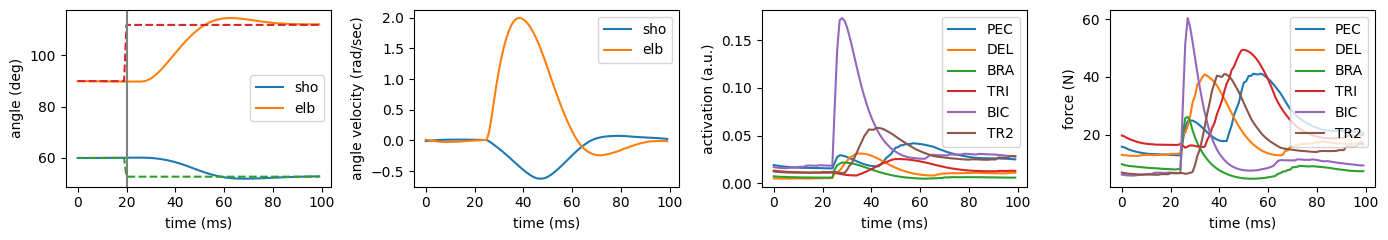

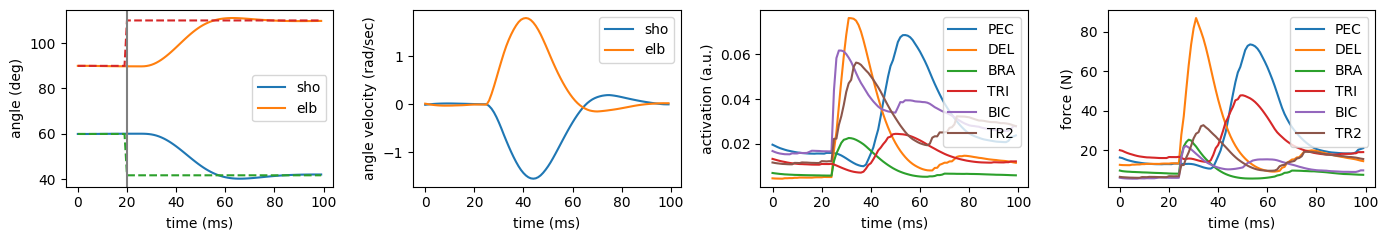

In [9]:
# test network in a NF in the centre-out reaching task
ff_coef = 0 # NF
test_net(nn, ff_coef=ff_coef)

# switch to SGD optimizer

In [10]:
# switch now to SGD optimizer

nn.compile(
    optimizer    = tf.optimizers.legacy.SGD(learning_rate = 0.001, 
                                            momentum      = 0.9
                                            ),
    loss         = nn.task.losses,
    loss_weights = nn.task.loss_weights
    )

# NF1

Epoch 1/100
30/30 [==============================] - 43s 1s/step - loss: 0.0595 - position_loss: 0.0229 - gru_regularizer_loss: 0.0325 - l2_xdx_activation_loss: 0.0018
Epoch 2/100
30/30 [==============================] - 31s 1s/step - loss: 0.0592 - position_loss: 0.0228 - gru_regularizer_loss: 0.0324 - l2_xdx_activation_loss: 0.0018
Epoch 3/100
30/30 [==============================] - 17s 576ms/step - loss: 0.0592 - position_loss: 0.0227 - gru_regularizer_loss: 0.0324 - l2_xdx_activation_loss: 0.0018
Epoch 4/100
30/30 [==============================] - 17s 572ms/step - loss: 0.0592 - position_loss: 0.0227 - gru_regularizer_loss: 0.0324 - l2_xdx_activation_loss: 0.0018
Epoch 5/100
30/30 [==============================] - 17s 582ms/step - loss: 0.0592 - position_loss: 0.0227 - gru_regularizer_loss: 0.0324 - l2_xdx_activation_loss: 0.0018
Epoch 6/100
30/30 [==============================] - 17s 566ms/step - loss: 0.0592 - position_loss: 0.0227 - gru_regularizer_loss: 0.0324 - l2_xdx_acti

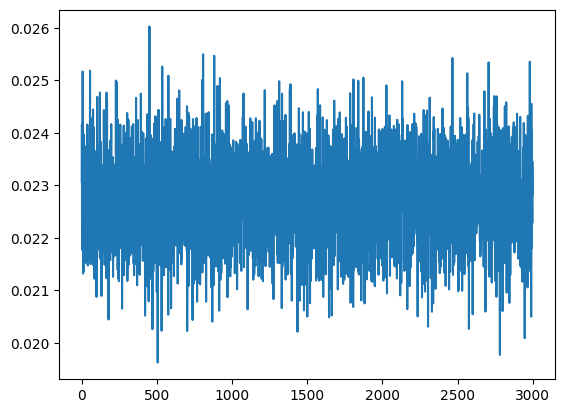

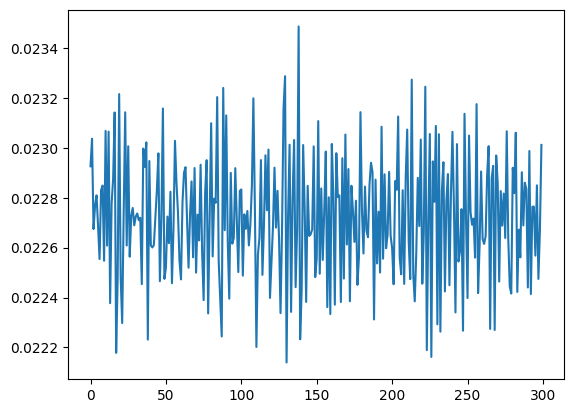

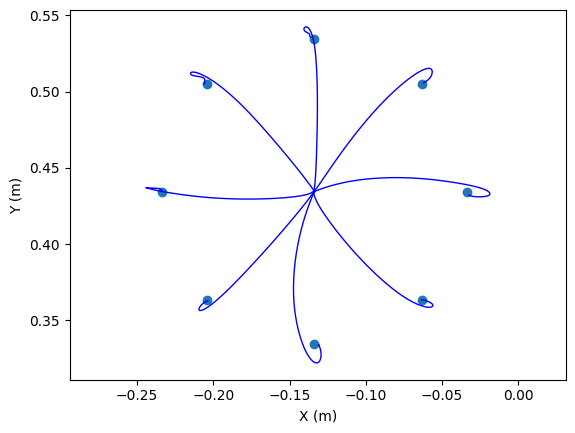

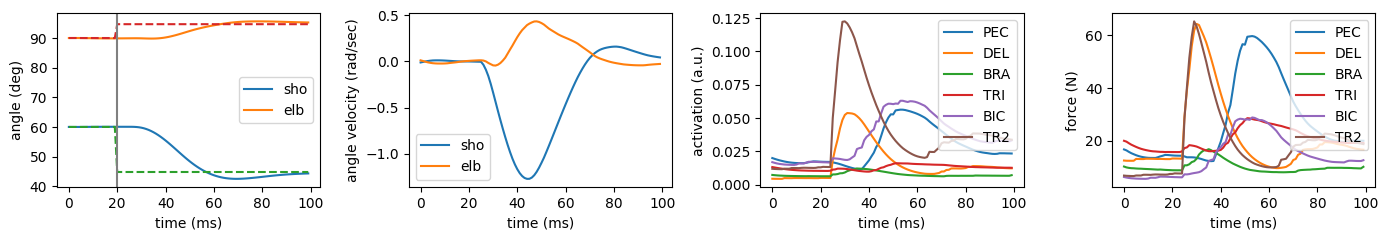

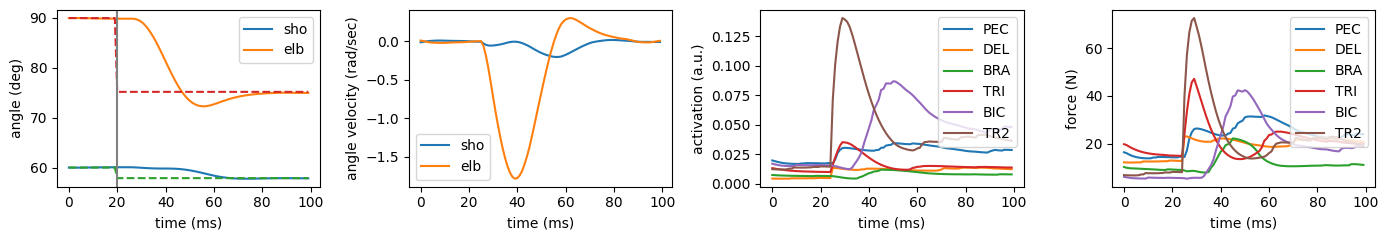

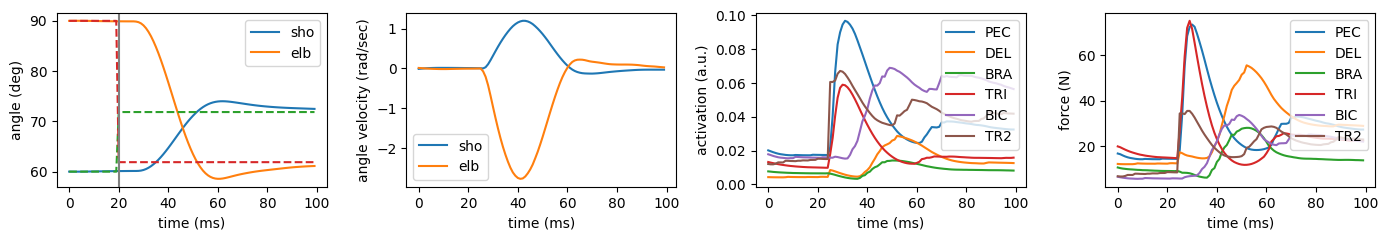

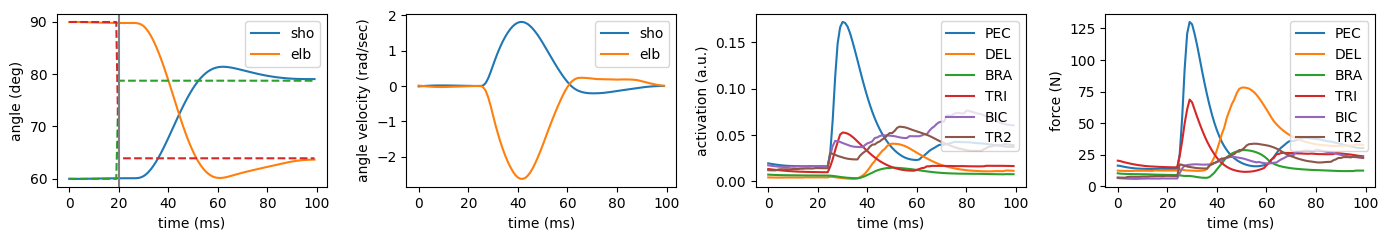

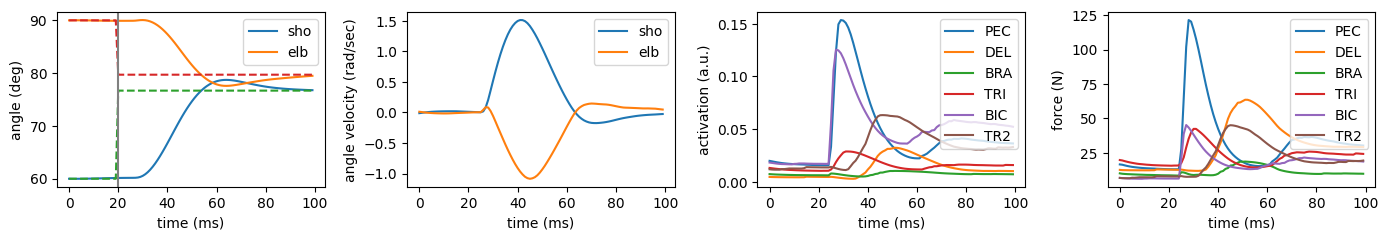

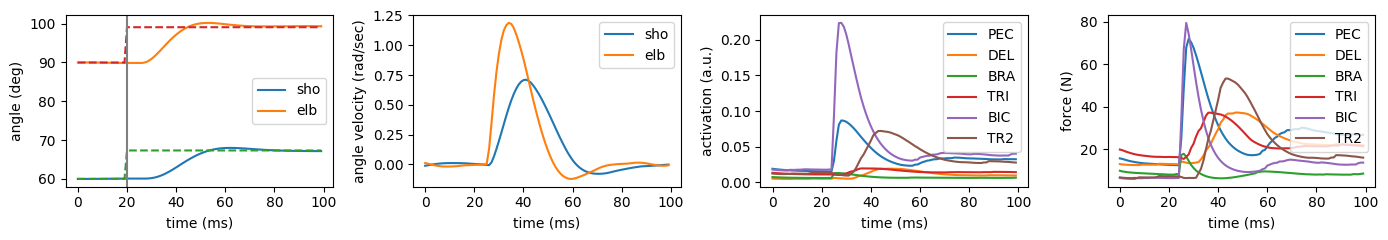

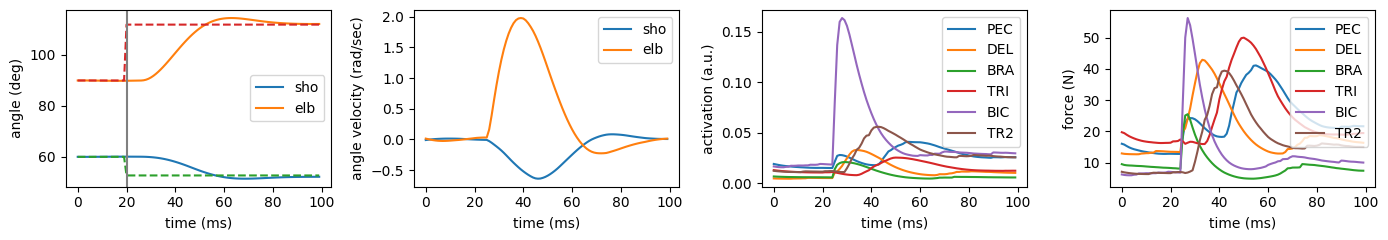

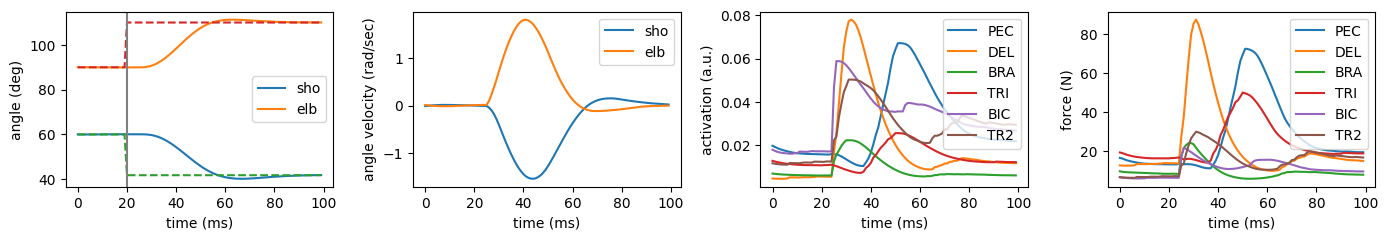

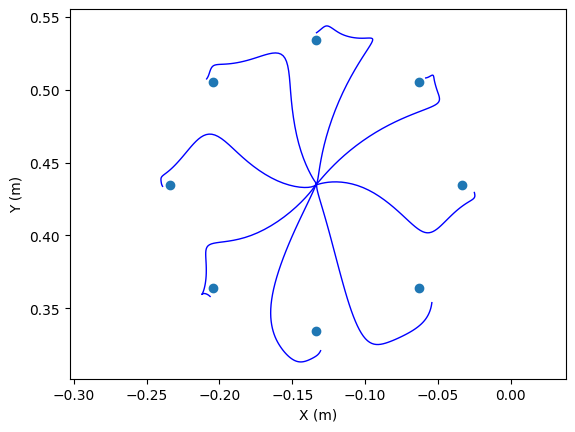

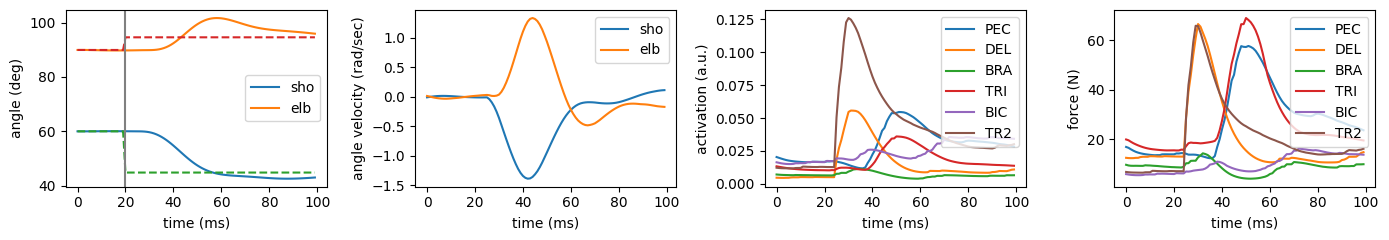

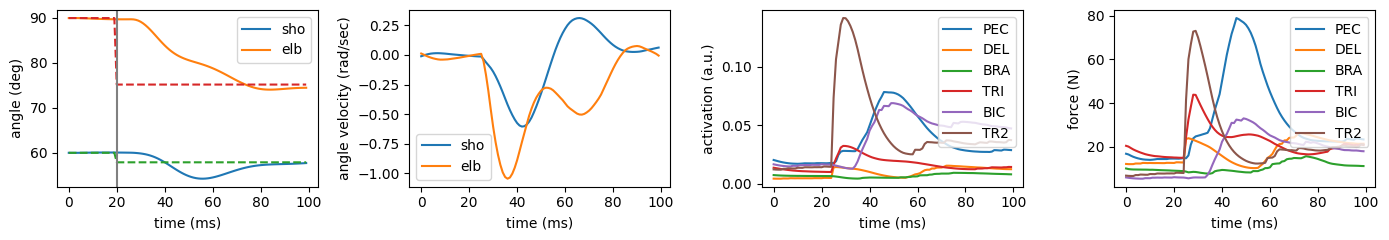

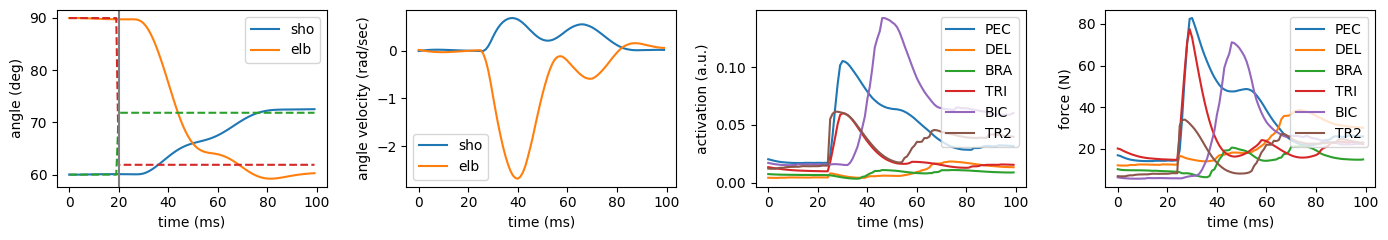

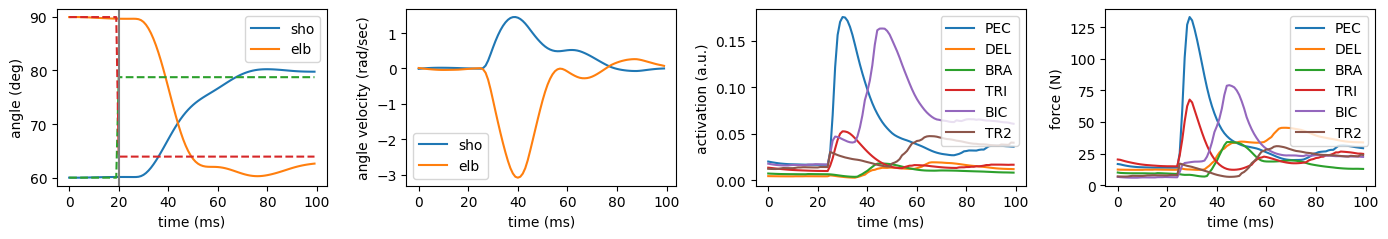

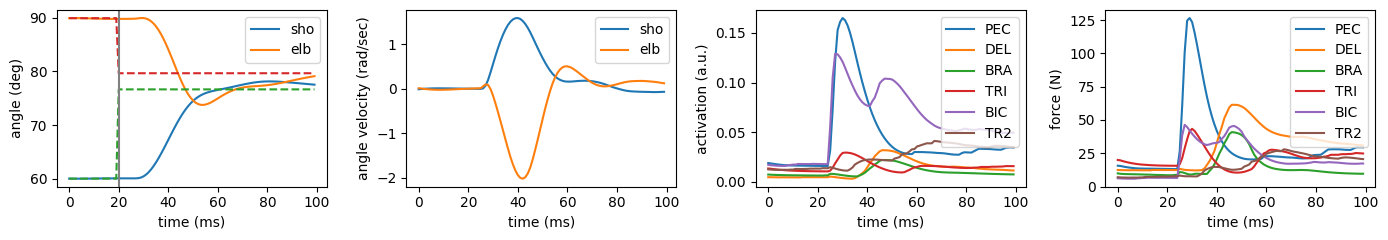

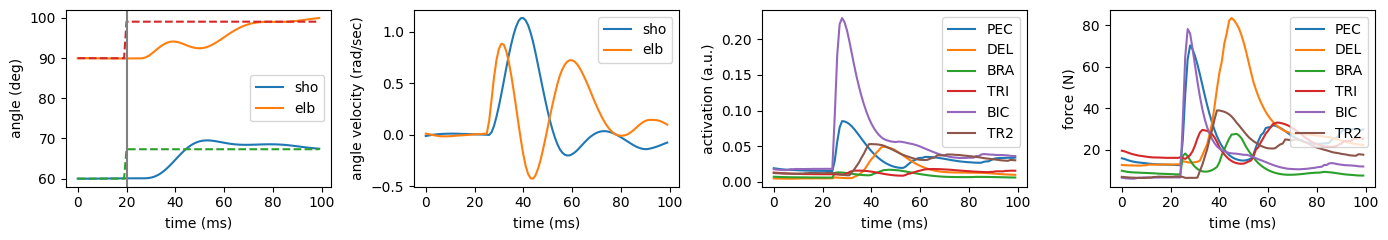

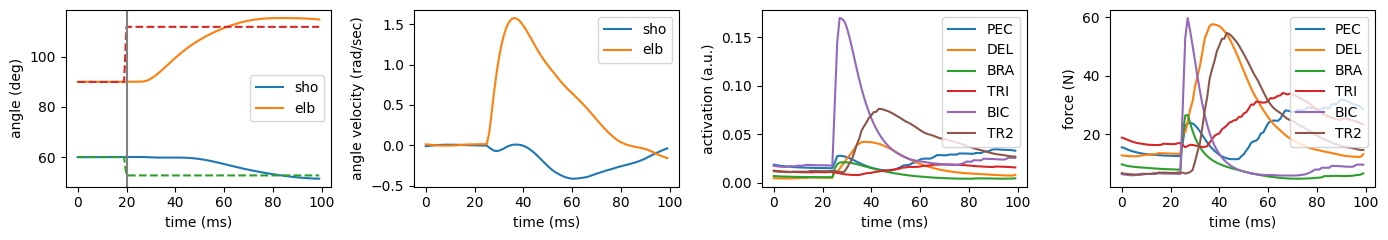

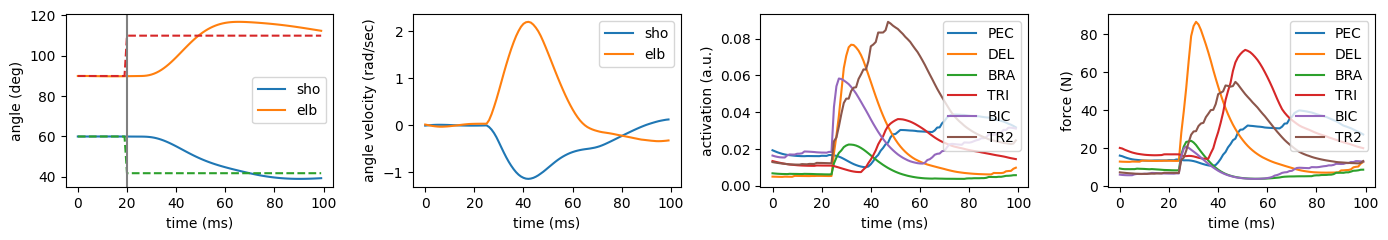

In [11]:
# re-train in a NF to get a measure of baseline position loss
ff_coef  = 0 # NF
position_loss_NF1 = train_net(nn, ff_coef=ff_coef)

# make some plots
plt.plot(position_loss_NF1)
plt.show()
NF1w = window_average(position_loss_NF1)
plt.plot(NF1w)
plt.show()

# test network in a NF in the centre-out reaching task
ff_coef = 0 # NF
test_net(nn, ff_coef=ff_coef)

# test network in a NF in the centre-out reaching task
ff_coef = 10 # CWFF
test_net(nn, ff_coef=ff_coef)

# FF1

Epoch 1/100
30/30 [==============================] - 17s 568ms/step - loss: 0.0706 - position_loss: 0.0267 - gru_regularizer_loss: 0.0389 - l2_xdx_activation_loss: 0.0024
Epoch 2/100
30/30 [==============================] - 17s 564ms/step - loss: 0.0683 - position_loss: 0.0260 - gru_regularizer_loss: 0.0371 - l2_xdx_activation_loss: 0.0022
Epoch 3/100
30/30 [==============================] - 17s 562ms/step - loss: 0.0673 - position_loss: 0.0256 - gru_regularizer_loss: 0.0366 - l2_xdx_activation_loss: 0.0022
Epoch 4/100
30/30 [==============================] - 17s 563ms/step - loss: 0.0667 - position_loss: 0.0254 - gru_regularizer_loss: 0.0364 - l2_xdx_activation_loss: 0.0021
Epoch 5/100
30/30 [==============================] - 17s 566ms/step - loss: 0.0662 - position_loss: 0.0252 - gru_regularizer_loss: 0.0363 - l2_xdx_activation_loss: 0.0021
Epoch 6/100
30/30 [==============================] - 17s 566ms/step - loss: 0.0659 - position_loss: 0.0251 - gru_regularizer_loss: 0.0362 - l2_xd

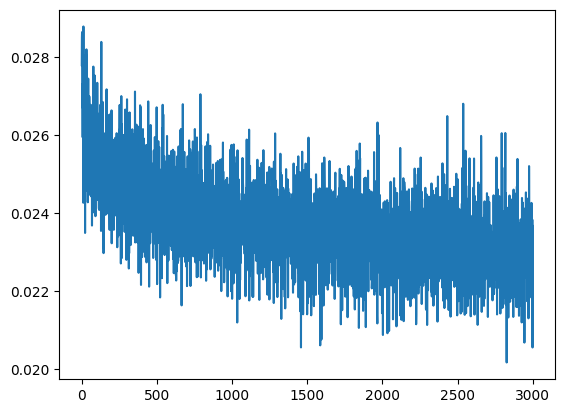

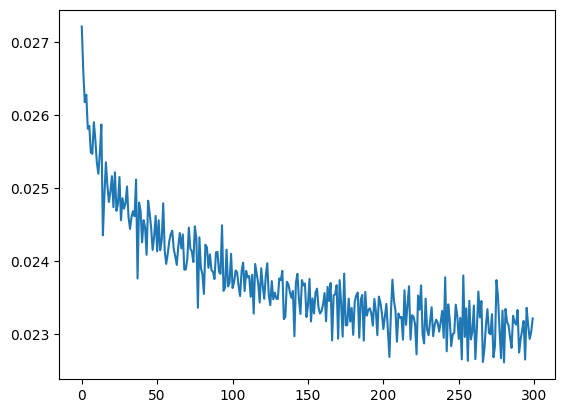

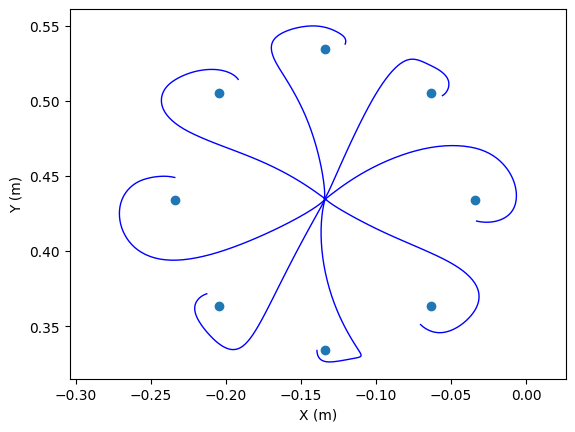

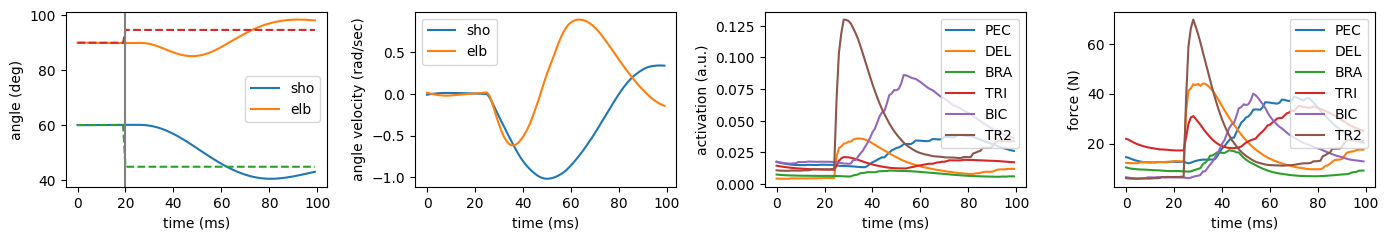

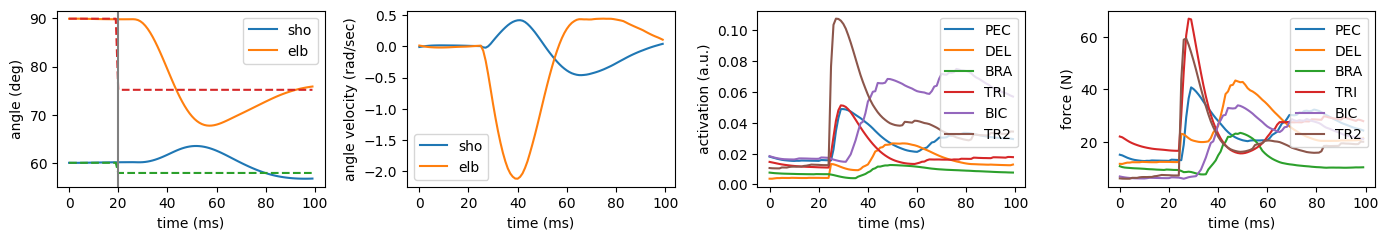

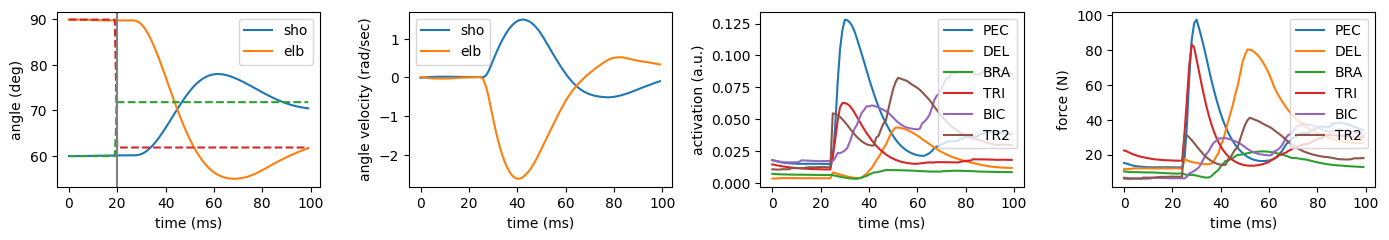

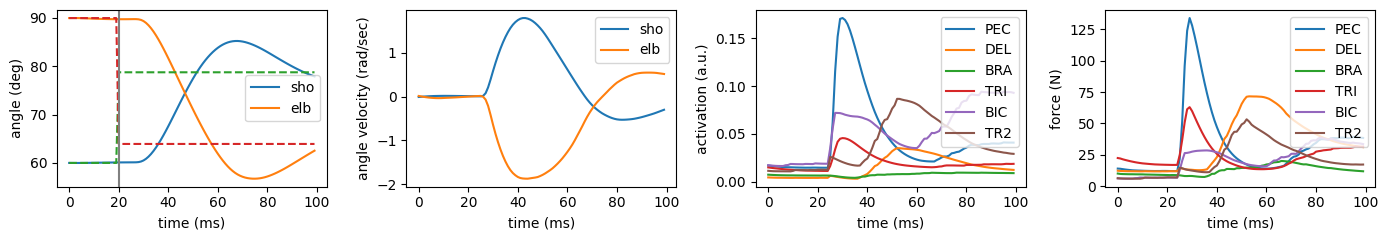

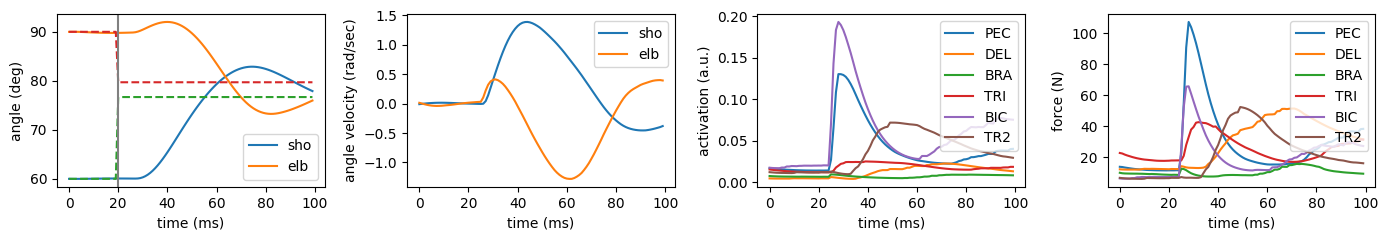

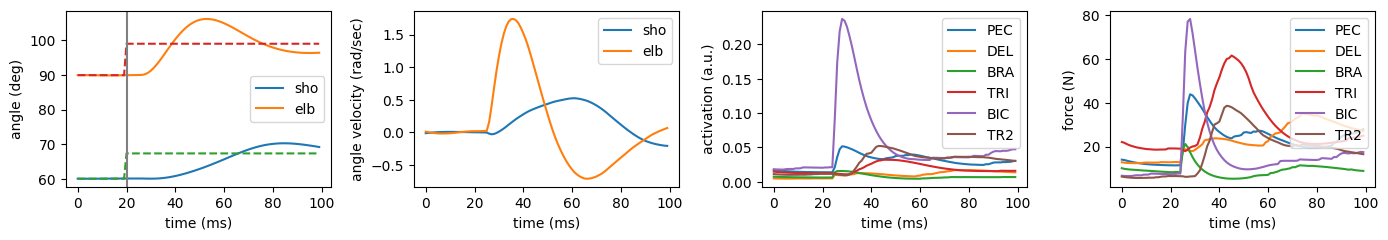

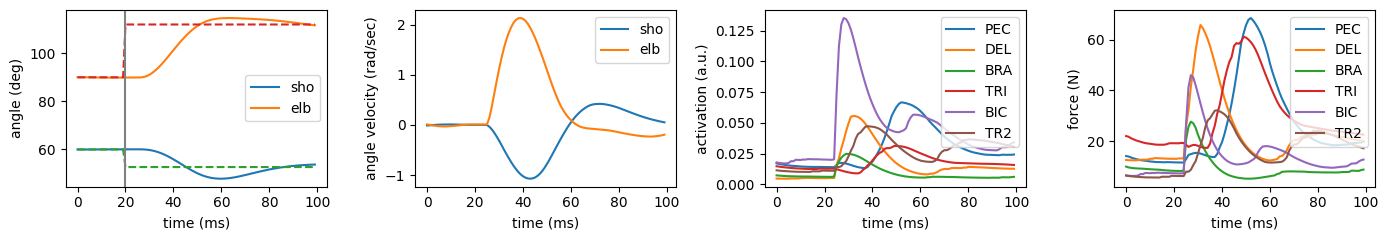

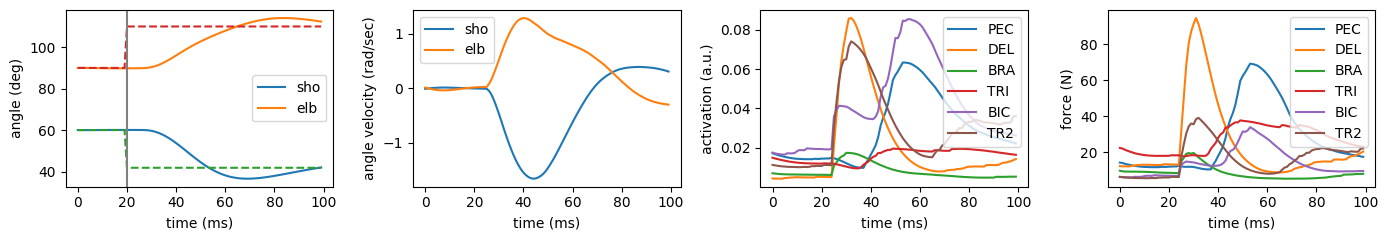

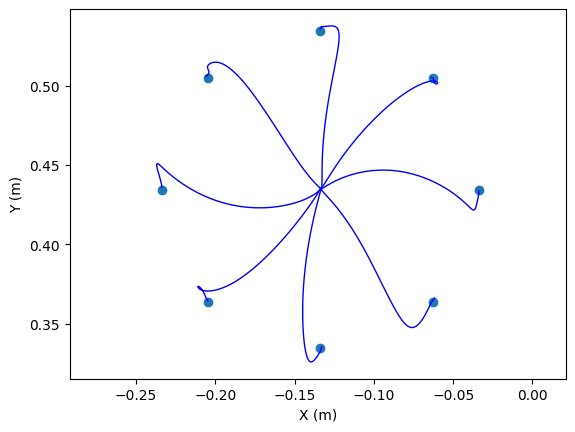

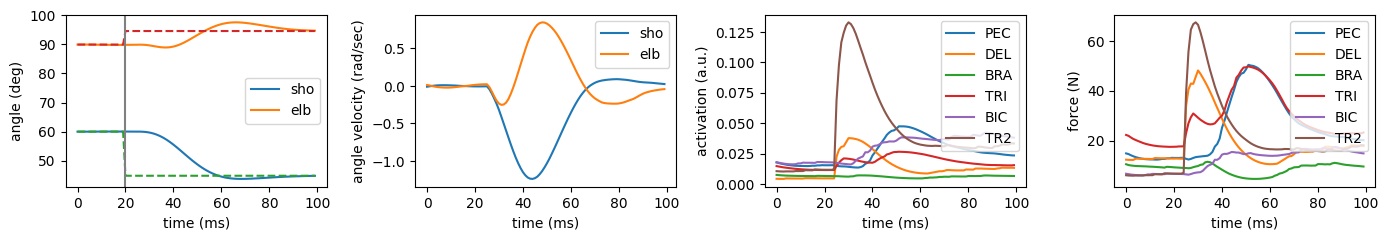

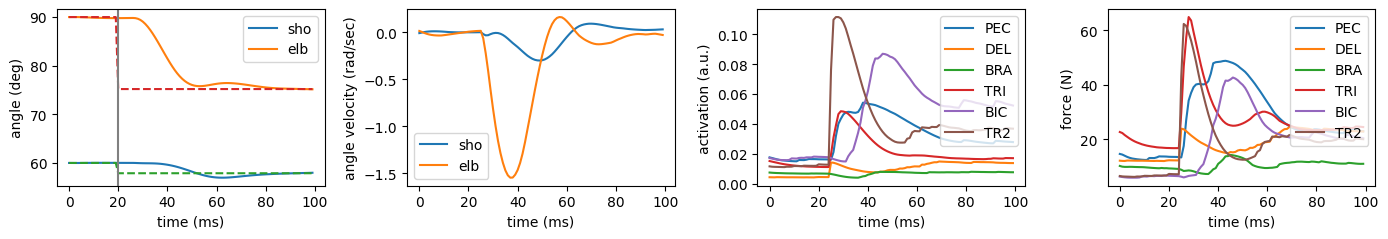

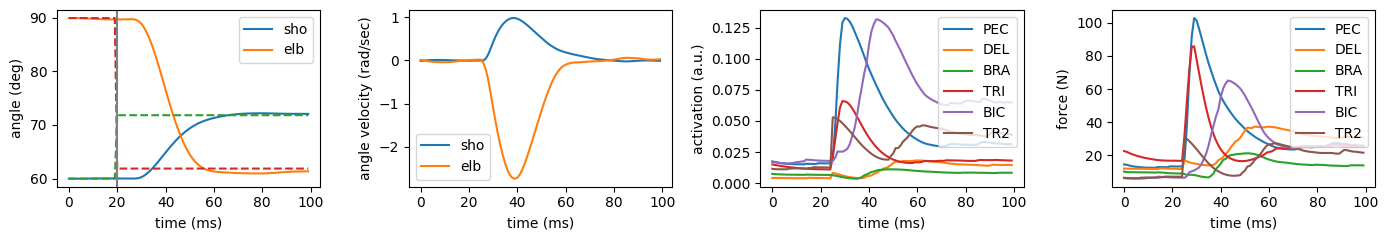

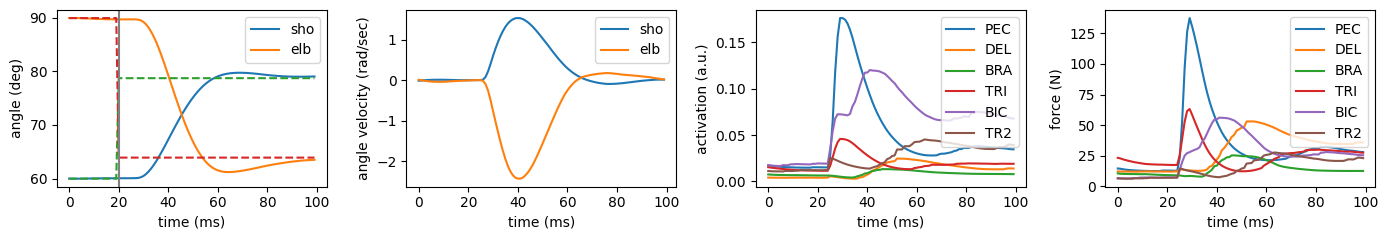

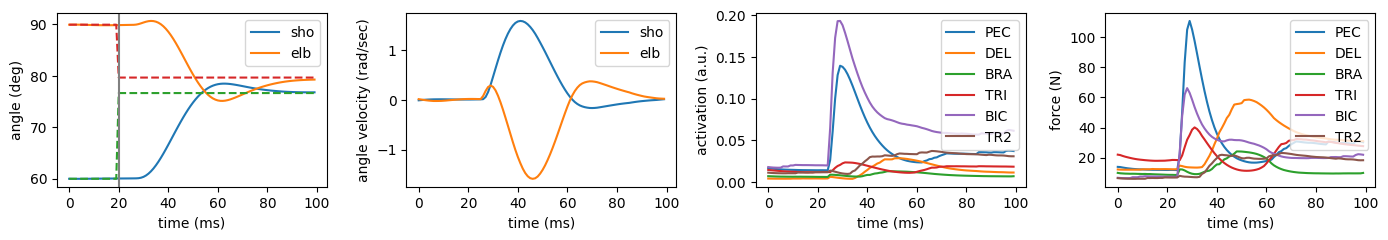

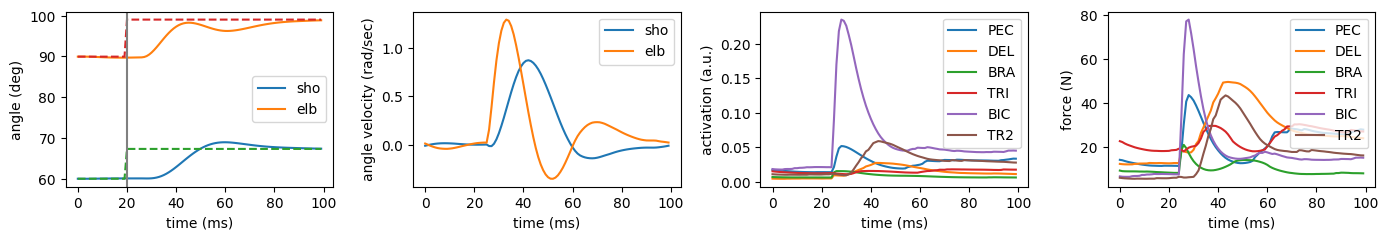

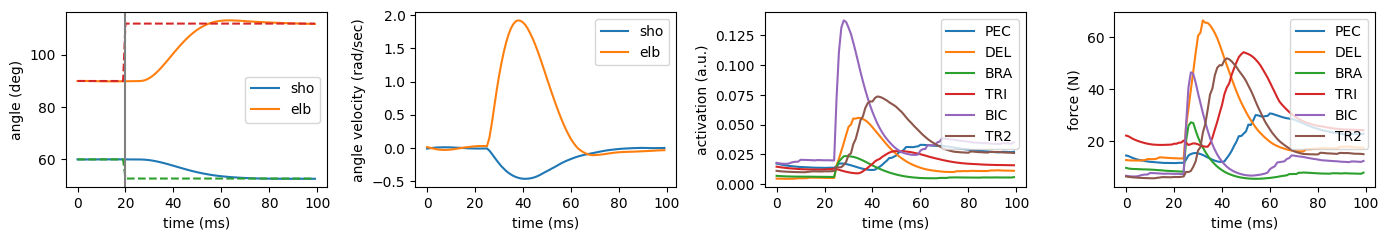

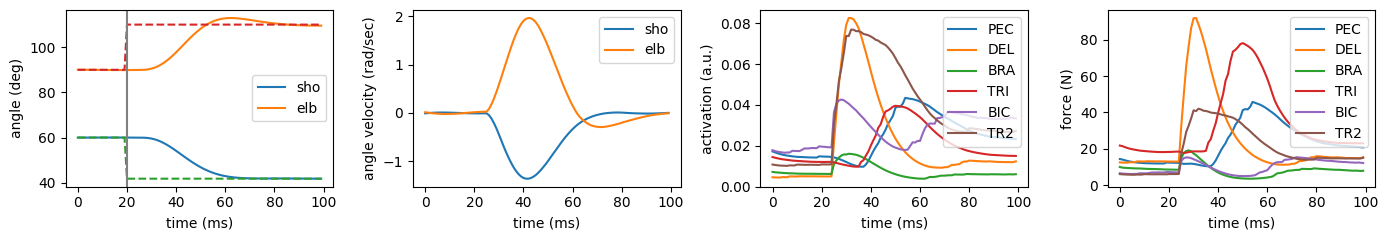

In [12]:
# train in a FF
ff_coef = 10 # CWFF
position_loss_FF1 = train_net(nn, ff_coef=ff_coef)

# make some plots
plt.plot(position_loss_FF1)
plt.show()
FF1w = window_average(position_loss_FF1)
plt.plot(FF1w)
plt.show()

# test network in a NF in the centre-out reaching task
ff_coef = 0 # NF
test_net(nn, ff_coef=ff_coef)

# test network in a NF in the centre-out reaching task
ff_coef = 10 # CWFF
test_net(nn, ff_coef=ff_coef)

# NF2 (washout)

Epoch 1/100
30/30 [==============================] - 15s 489ms/step - loss: 0.0735 - position_loss: 0.0284 - gru_regularizer_loss: 0.0415 - l2_xdx_activation_loss: 0.0022
Epoch 2/100
30/30 [==============================] - 14s 483ms/step - loss: 0.0674 - position_loss: 0.0261 - gru_regularizer_loss: 0.0373 - l2_xdx_activation_loss: 0.0020
Epoch 3/100
30/30 [==============================] - 14s 479ms/step - loss: 0.0649 - position_loss: 0.0250 - gru_regularizer_loss: 0.0356 - l2_xdx_activation_loss: 0.0020
Epoch 4/100
30/30 [==============================] - 15s 486ms/step - loss: 0.0637 - position_loss: 0.0245 - gru_regularizer_loss: 0.0349 - l2_xdx_activation_loss: 0.0020
Epoch 5/100
30/30 [==============================] - 14s 480ms/step - loss: 0.0629 - position_loss: 0.0242 - gru_regularizer_loss: 0.0344 - l2_xdx_activation_loss: 0.0019
Epoch 6/100
30/30 [==============================] - 15s 487ms/step - loss: 0.0625 - position_loss: 0.0240 - gru_regularizer_loss: 0.0340 - l2_xd

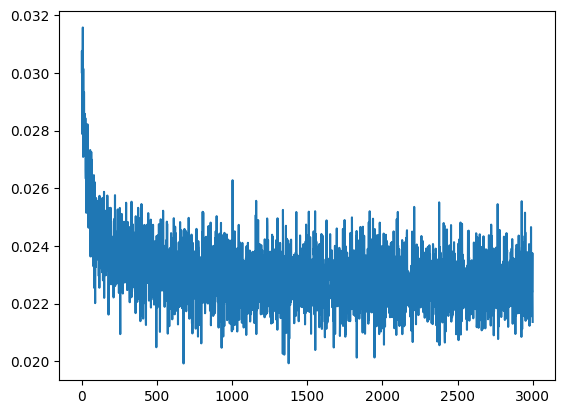

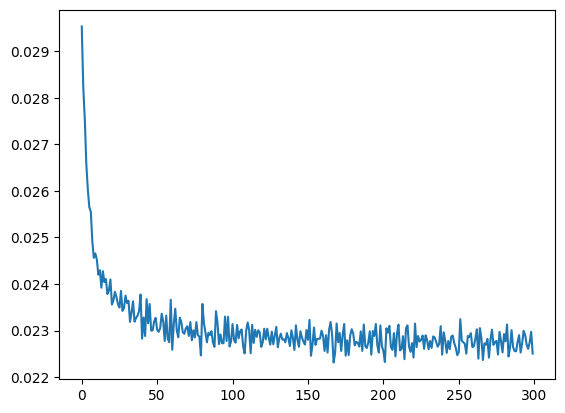

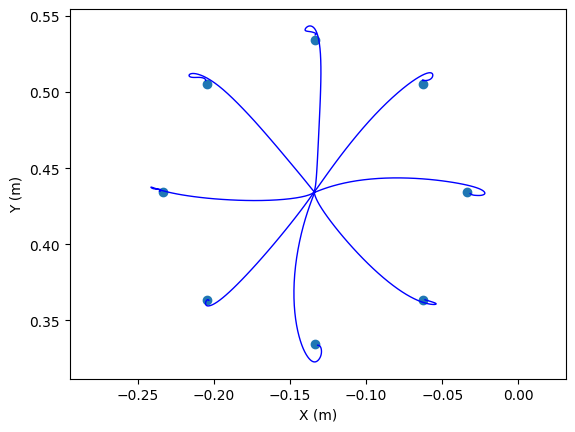

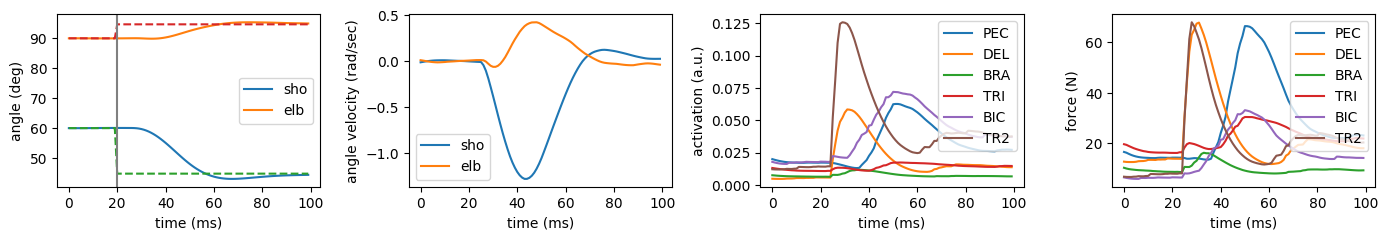

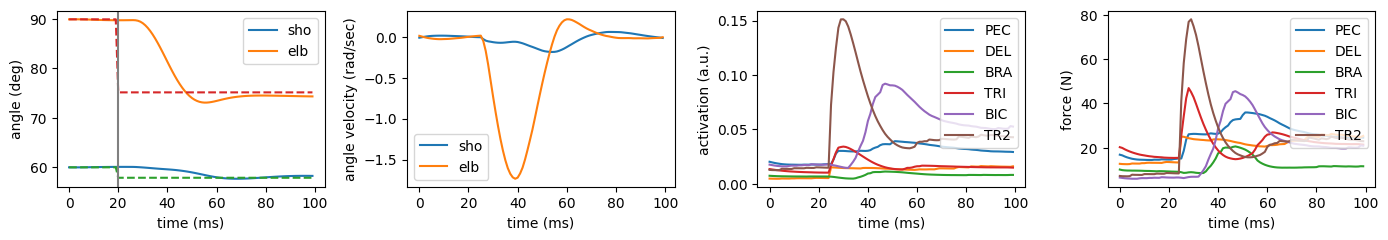

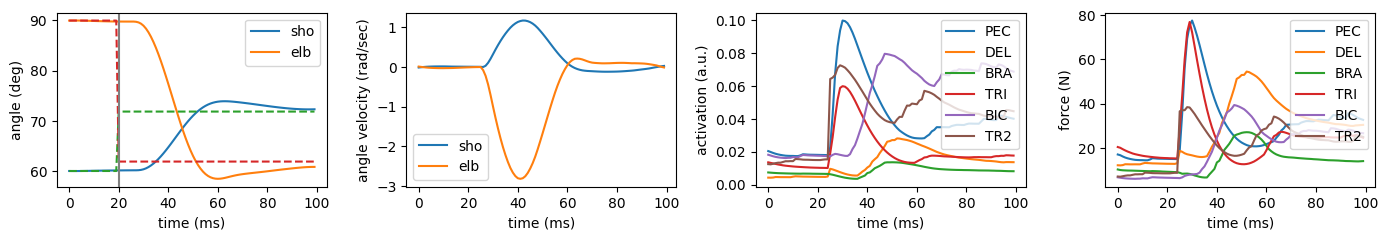

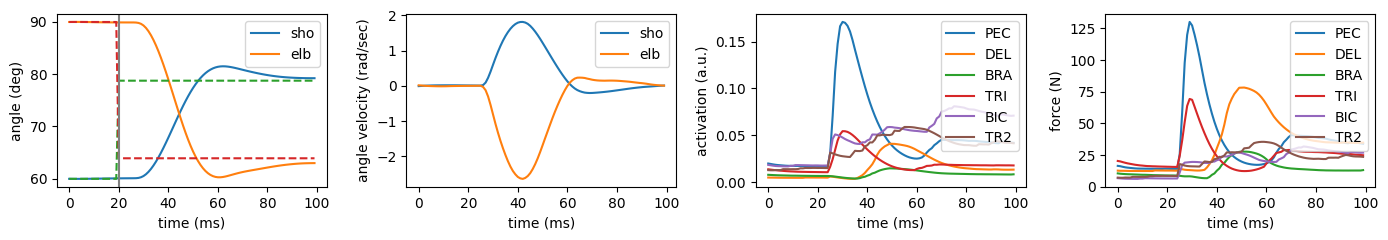

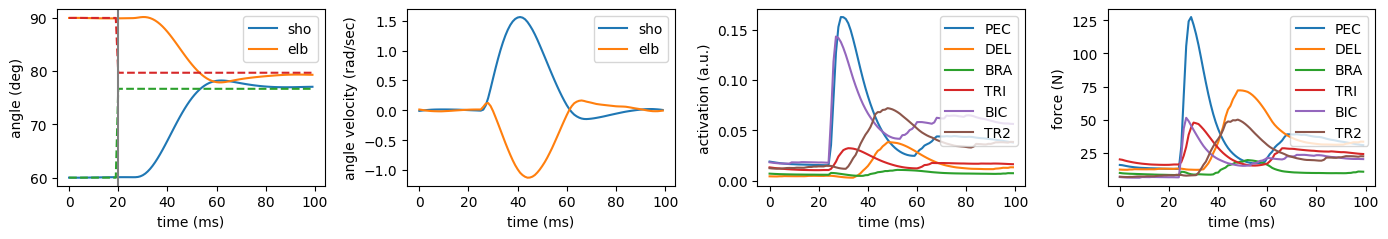

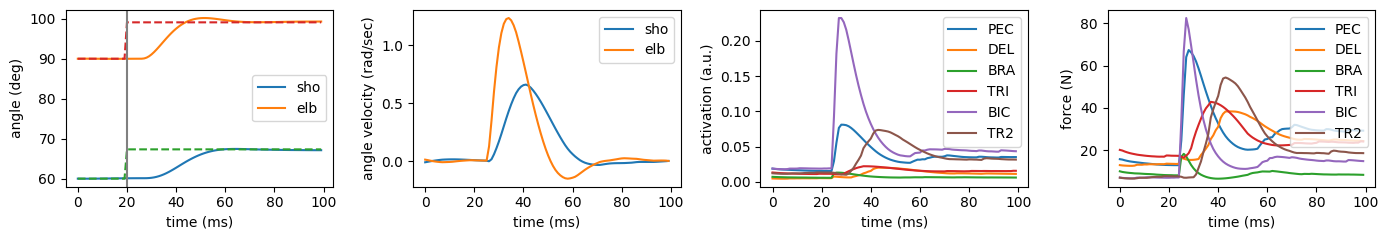

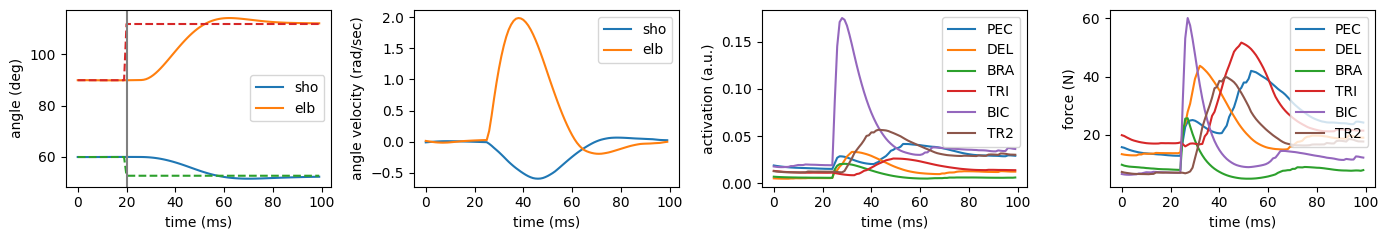

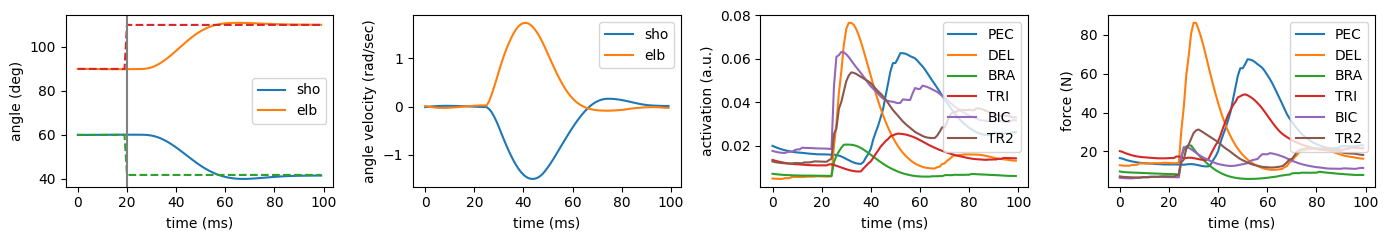

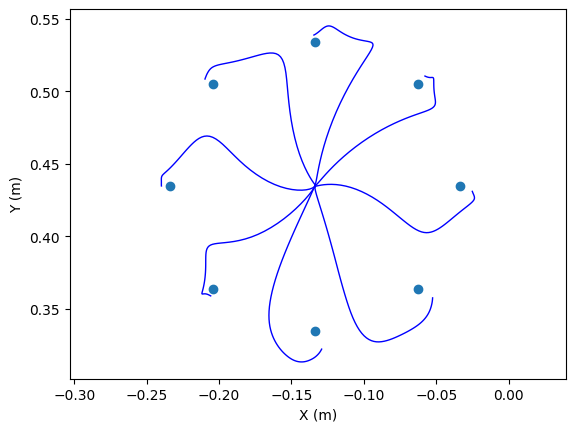

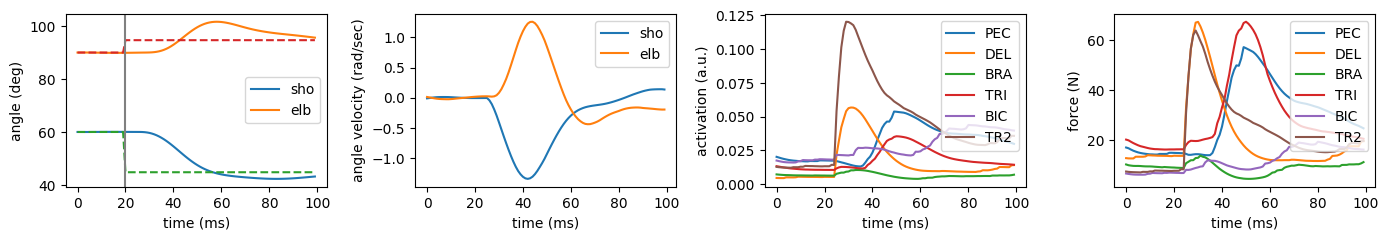

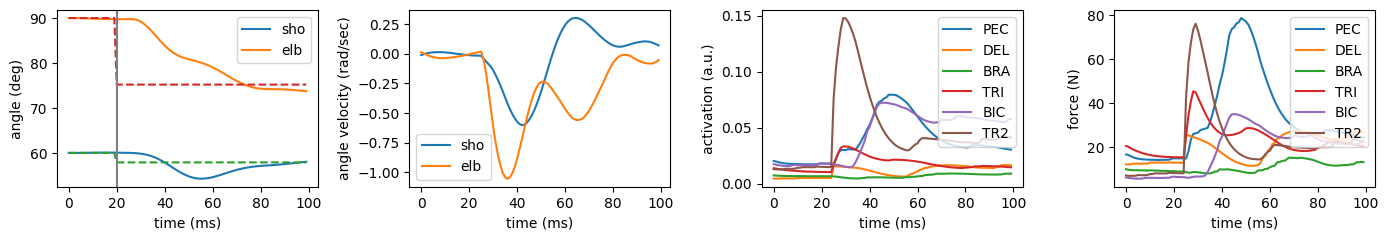

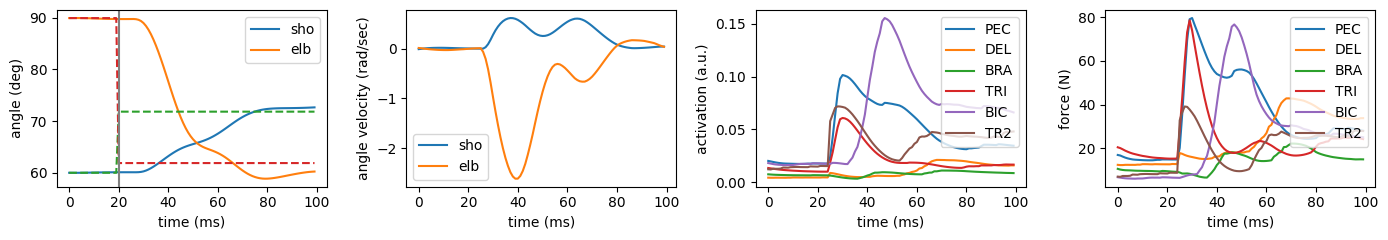

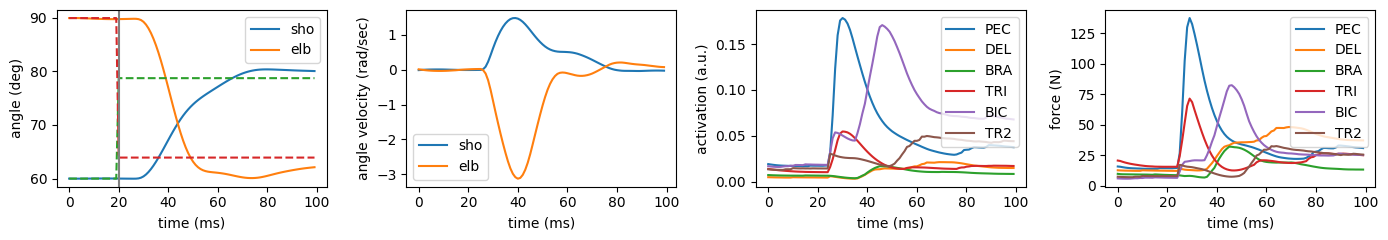

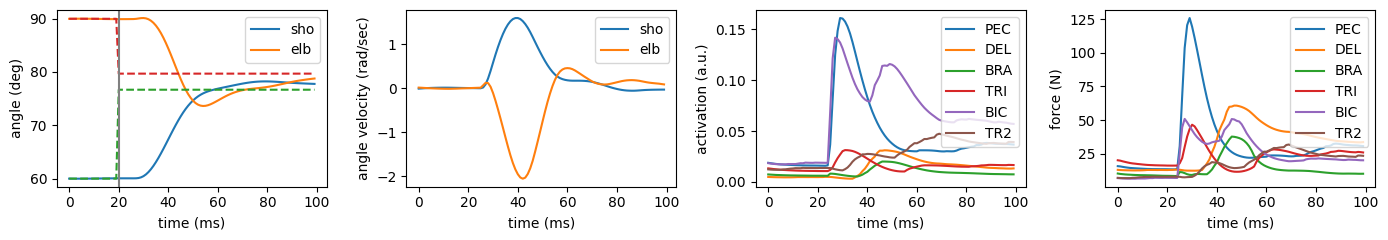

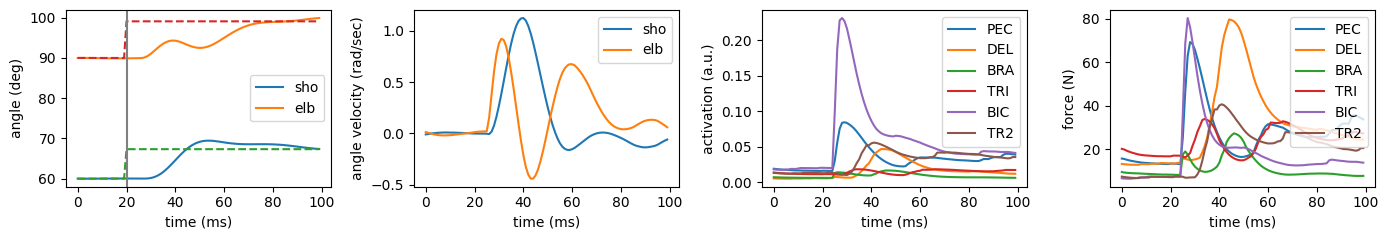

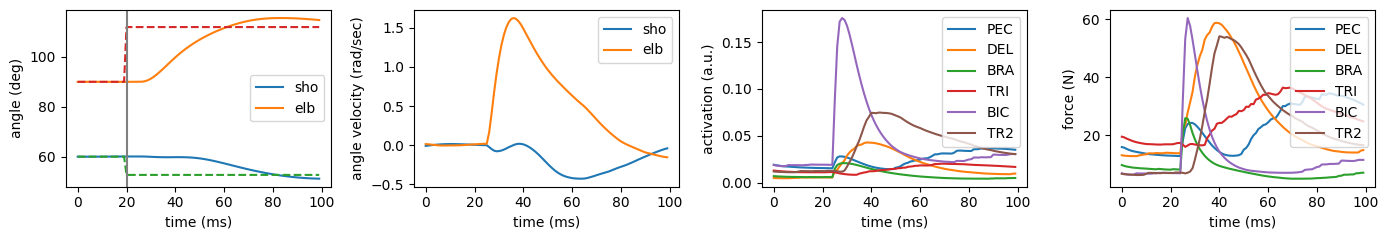

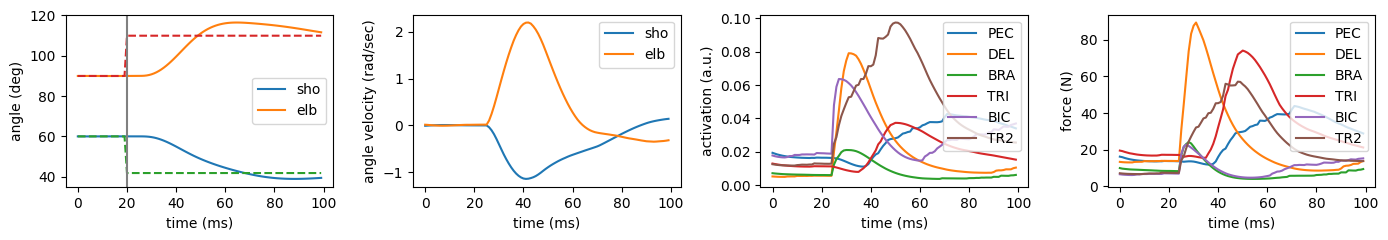

In [13]:
# train in a NF2
ff_coef = 0 # NF
position_loss_NF2 = train_net(nn, ff_coef=ff_coef,n_epochs=100)

# make some plots
plt.plot(position_loss_NF2)
plt.show()
NF2w = window_average(position_loss_NF2, 10)
plt.plot(NF2w)
plt.show()

# test network in a NF in the centre-out reaching task
ff_coef = 0 # NF
test_net(nn, ff_coef=ff_coef)

# test network in a NF in the centre-out reaching task
ff_coef = 10 # CWFF
test_net(nn, ff_coef=ff_coef)

# FF2 (savings?)

Epoch 1/100
30/30 [==============================] - 15s 496ms/step - loss: 0.0689 - position_loss: 0.0261 - gru_regularizer_loss: 0.0361 - l2_xdx_activation_loss: 0.0023
Epoch 2/100
30/30 [==============================] - 14s 482ms/step - loss: 0.0669 - position_loss: 0.0253 - gru_regularizer_loss: 0.0354 - l2_xdx_activation_loss: 0.0023
Epoch 3/100
30/30 [==============================] - 14s 482ms/step - loss: 0.0658 - position_loss: 0.0249 - gru_regularizer_loss: 0.0350 - l2_xdx_activation_loss: 0.0022
Epoch 4/100
30/30 [==============================] - 14s 480ms/step - loss: 0.0652 - position_loss: 0.0247 - gru_regularizer_loss: 0.0348 - l2_xdx_activation_loss: 0.0022
Epoch 5/100
30/30 [==============================] - 15s 489ms/step - loss: 0.0647 - position_loss: 0.0246 - gru_regularizer_loss: 0.0346 - l2_xdx_activation_loss: 0.0021
Epoch 6/100
30/30 [==============================] - 14s 481ms/step - loss: 0.0643 - position_loss: 0.0244 - gru_regularizer_loss: 0.0346 - l2_xd

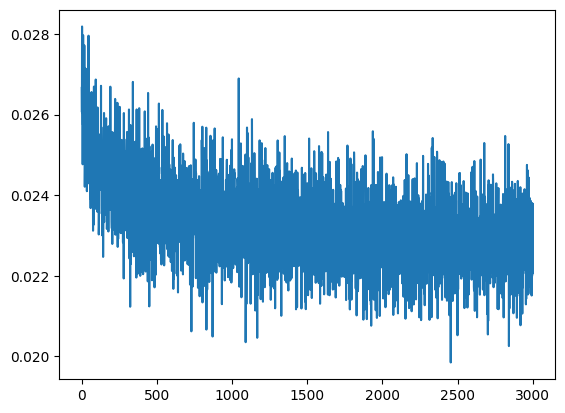

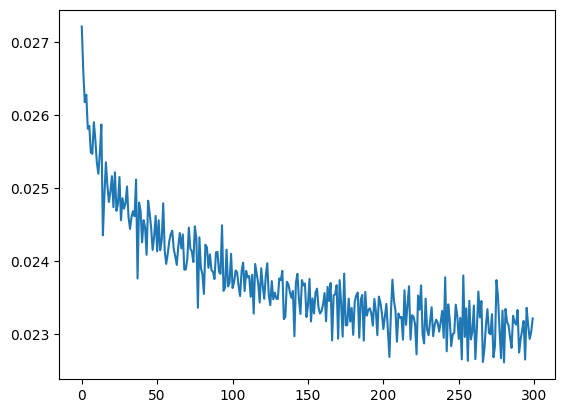

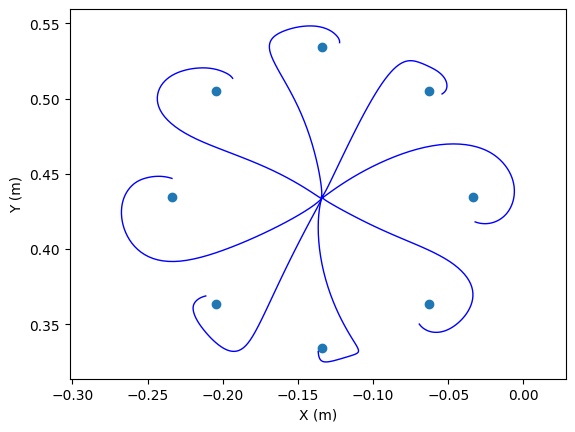

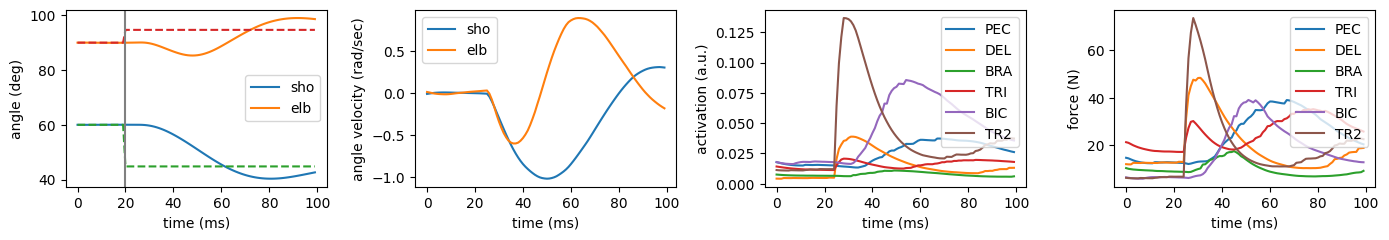

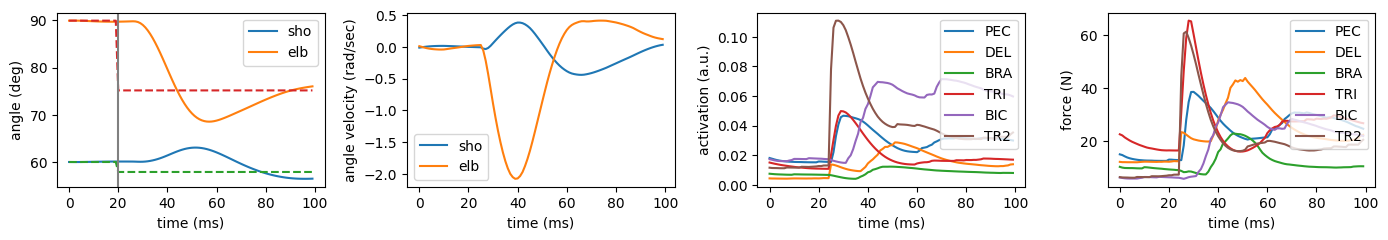

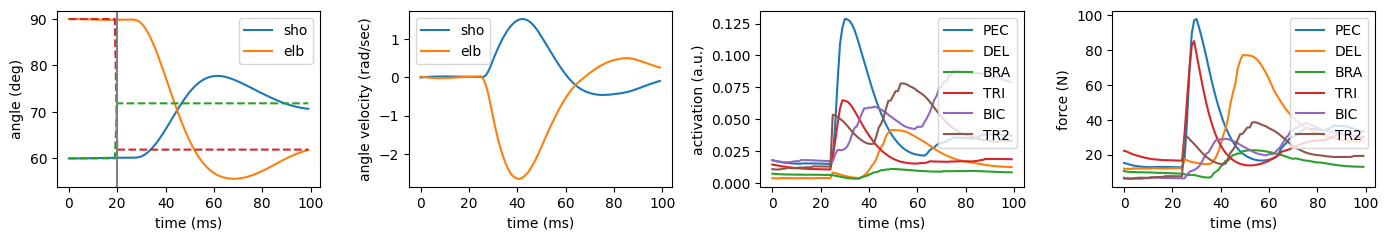

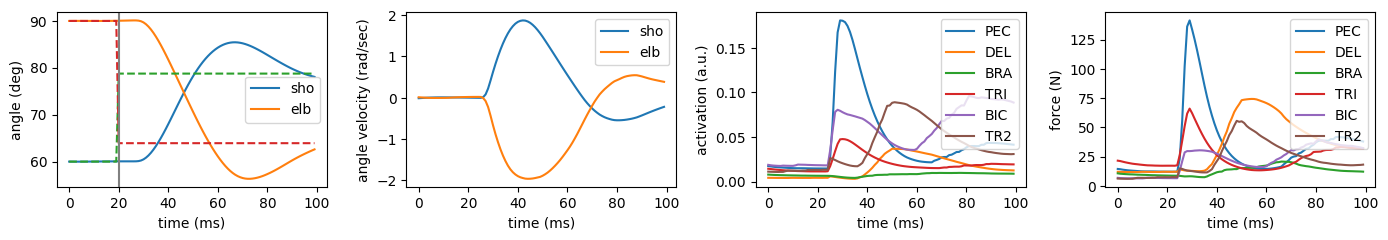

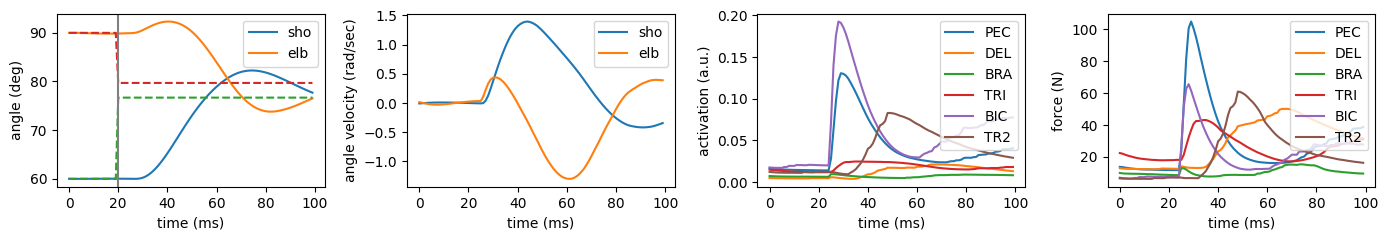

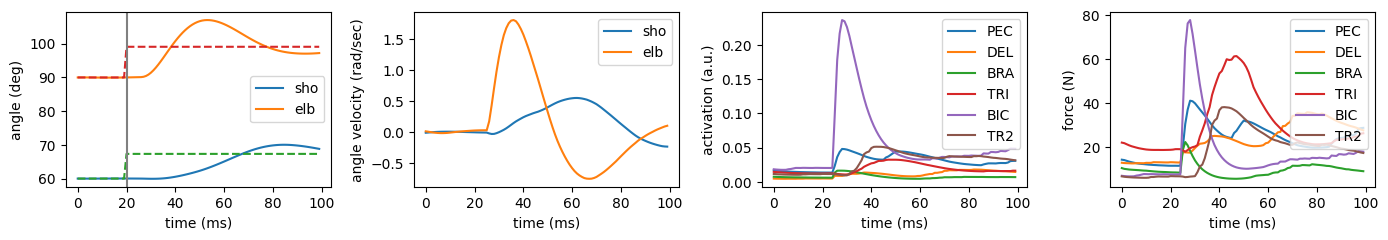

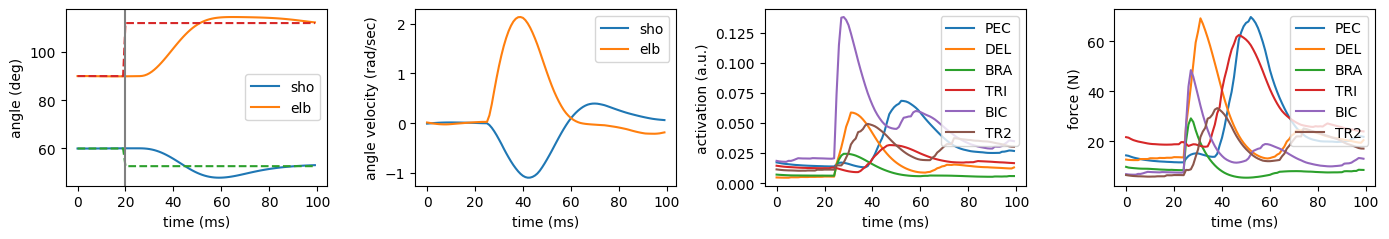

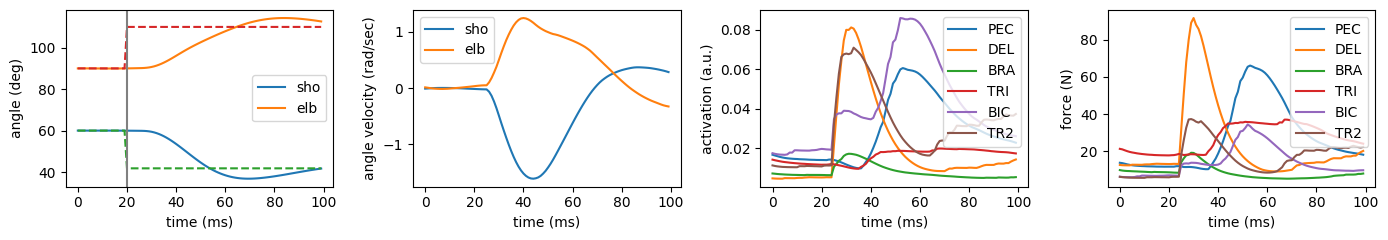

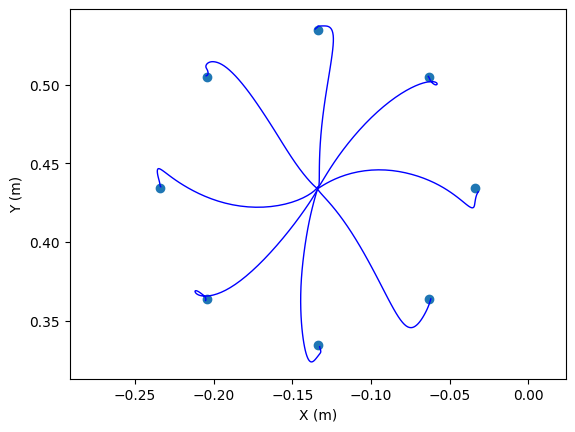

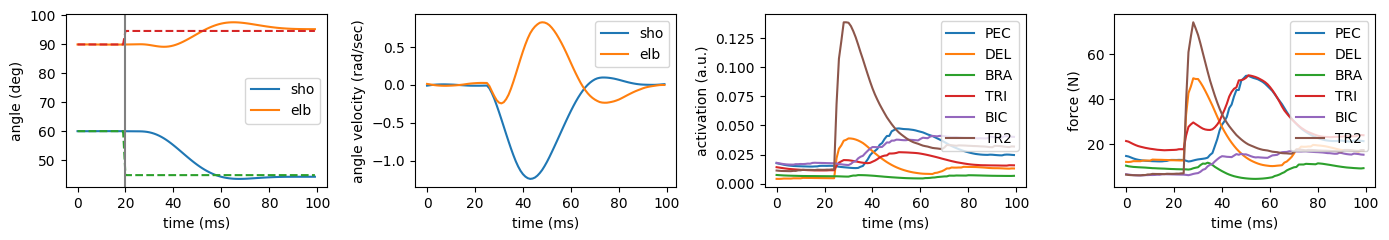

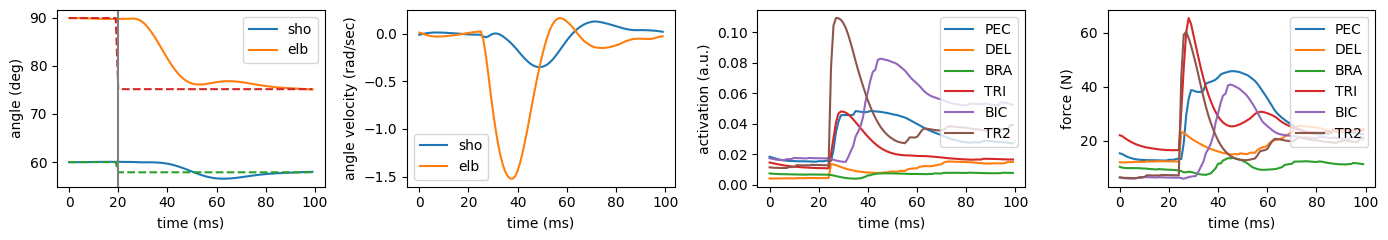

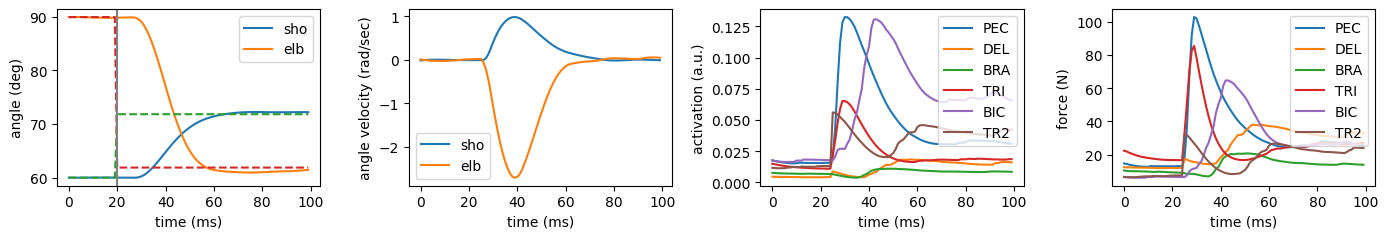

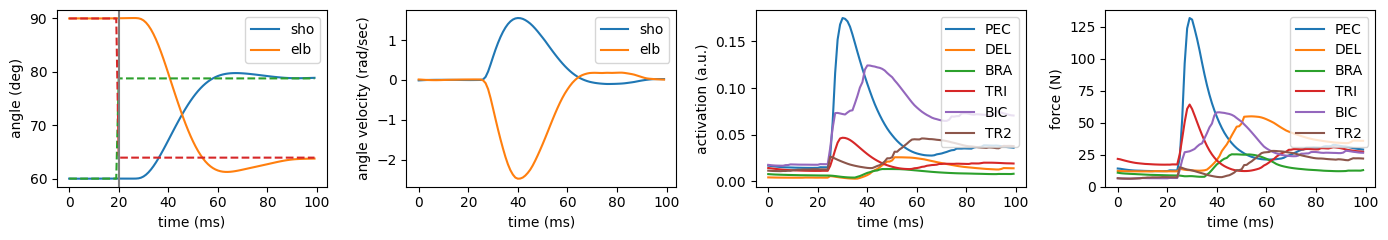

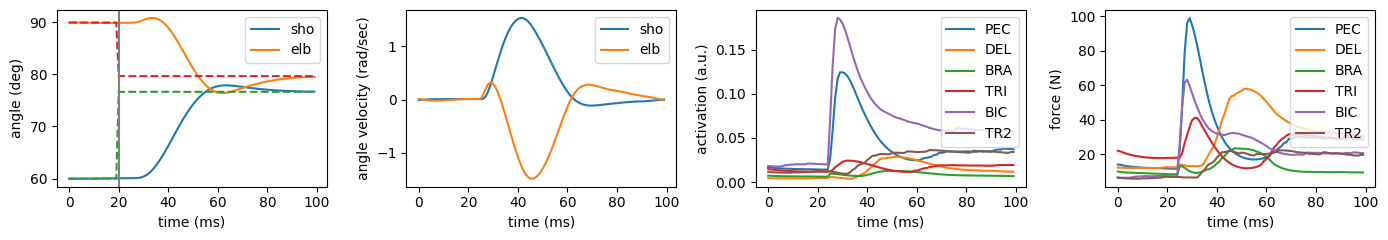

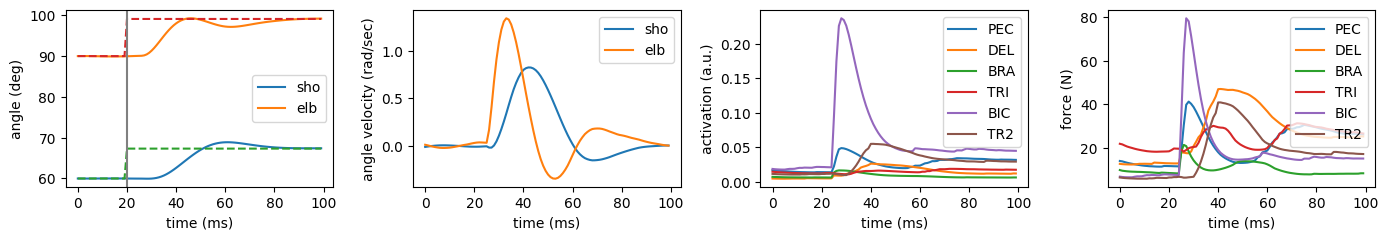

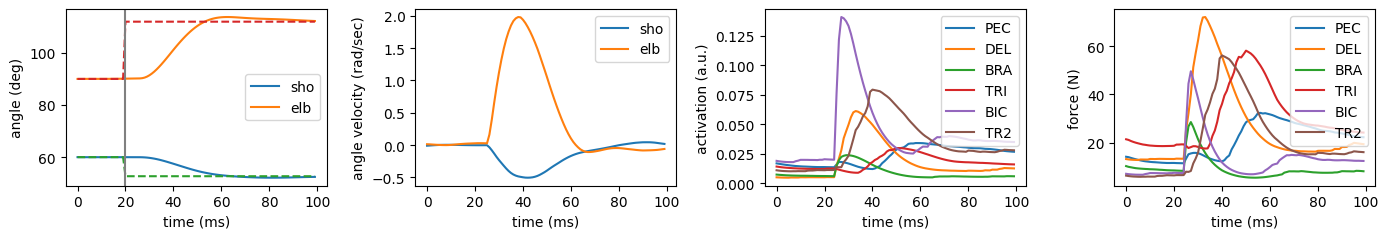

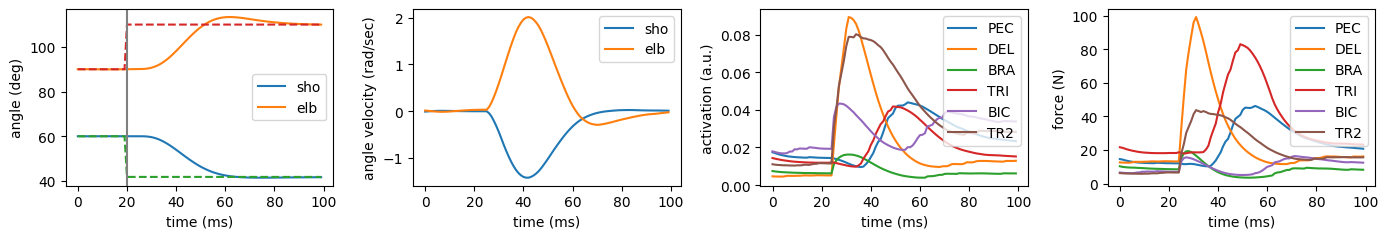

In [14]:
# train in a FF2
ff_coef = 10 # CWFF
position_loss_FF2 = train_net(nn, ff_coef=ff_coef)

# make some plots
plt.plot(position_loss_FF2)
plt.show()
FF2w = window_average(position_loss_FF2)
plt.plot(FF1w)
plt.show()

# test network in a NF in the centre-out reaching task
ff_coef = 0 # NF
test_net(nn, ff_coef=ff_coef)

# test network in a NF in the centre-out reaching task
ff_coef = 10 # CWFF
test_net(nn, ff_coef=ff_coef)

# Plot learning curves

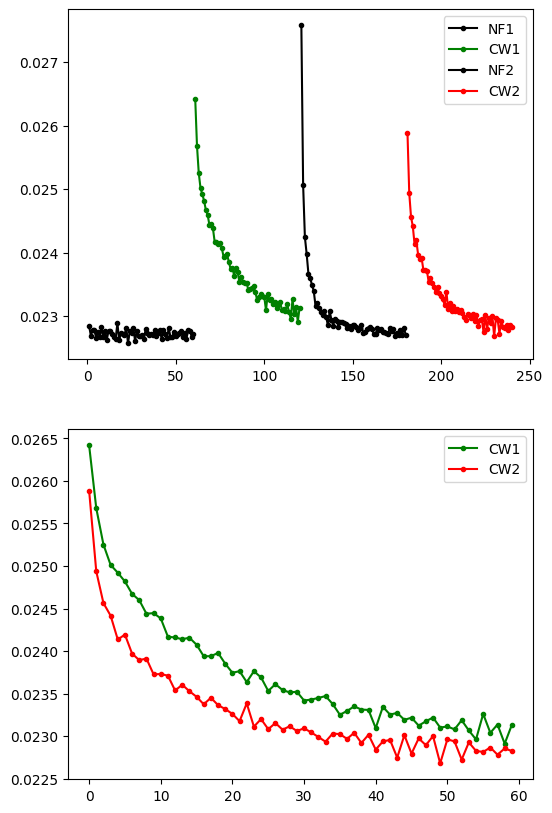

In [18]:
w = 50
NF1w = window_average(position_loss_NF1,w)
FF1w = window_average(position_loss_FF1,w)
NF2w = window_average(position_loss_NF2,w)
FF2w = window_average(position_loss_FF2,w)

x1w = np.arange(1,np.shape(NF1w)[0]+1)
x2w = np.arange(1,np.shape(FF1w)[0]+1) + x1w[-1]
x3w = np.arange(1,np.shape(NF2w)[0]+1) + x2w[-1]
x4w = np.arange(1,np.shape(FF2w)[0]+1) + x3w[-1]

np.savez('savings2.npz', NF1w, FF1w, NF2w, FF2w, x1w, x2w, x3w, x4w)

fig,ax = plt.subplots(2,1,figsize=(6,10))
l1, = ax[0].plot(x1w,NF1w,'k.-')
l2, = ax[0].plot(x2w,FF1w,'g.-')
l3, = ax[0].plot(x3w,NF2w,'k.-')
l4, = ax[0].plot(x4w,FF2w,'r.-')
ax[0].legend([l1,l2,l3,l4],['NF1','CW1','NF2','CW2'])

l2, = ax[1].plot(FF1w,'g.-')
l4, = ax[1].plot(FF2w,'r.-')
ax[1].legend([l2,l4],['CW1','CW2'])